# Spatial averaging for multi frequency Celwave PD620 omni antenna
This notebook analyses scaled versions of the PD620 omni antenna for various frequencies

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 27/9/2023

+ FEKO data provided by Danie Ludick
+ Antenna model is the FEKO IXUS version of the Celwave PD620. It has a relatively **wide** vertical beam.
+ Modelled frequencies: **70, 180, 400, 700 & 1000** MHz
+ The FEKO models were appropriately scaled for each frequency
+ FEKO phantom uses the *original* (trial 1) tissue dielectric values
+ Uses `RFcalcs_v01` module
+ Spatial averaging includes [Simpsons 1/3 Rule](https://2fc.gitbook.io/spatial-avg-wg/methodology/numerical-approaches-for-spatial-averaging#simpsons-one-third-rule) and [Gaussian Quadrature](https://pomax.github.io/bezierinfo/legendre-gauss.htmlhttps://pomax.github.io/bezierinfo/legendre-gauss.html) approaches
+ The 1.6m 17-point scheme using Simpsons 1/3 Rule is deemed the 'near-perfect' solution of the spatial average

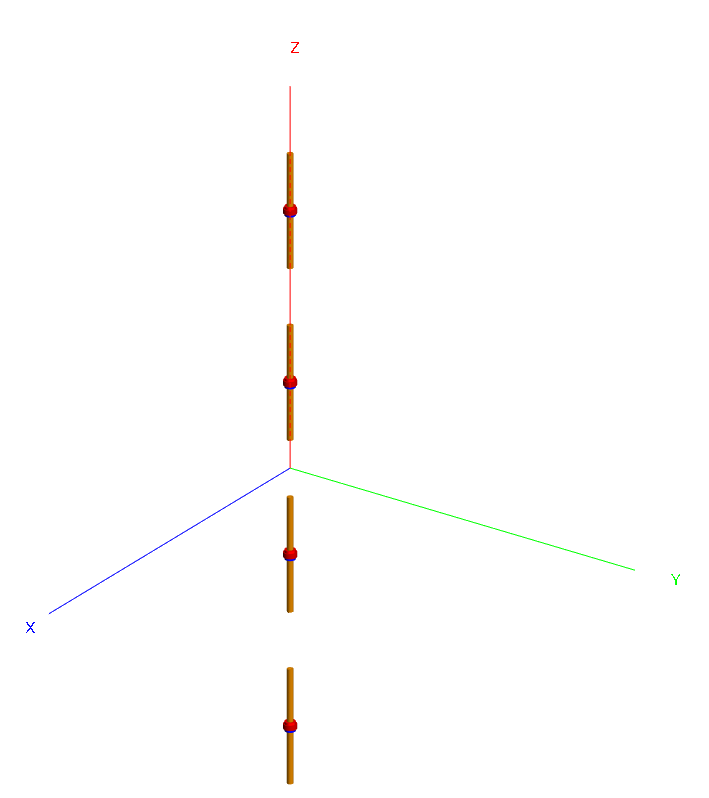

## Load necessary python modules

In [340]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from scipy.interpolate import interp1d
import altair as alt
from scipy import stats
from scipy import interpolate
from collections.abc import Iterable
import textwrap as tr
import pandas as pd
from RFcalcs_v01 import *
pd.set_option('display.max_rows', 180)
from icecream import ic
from pprint import pprint
import seaborn as sns

# Set folder locations for antenna, plots and outputs
%cd -0
%cd ../
ANTDIR = './antennas/'
PLOTDIR = './antennas/omni/plots/'
OUTDIR = './antennas/omni/outputs/'

# Disable cell warnings (for seaborn warnings)
import warnings
warnings.filterwarnings('ignore')

# Set antenna parameters
POWER = 100      # nominal radiated power of the omni antennas
POWER_LOW = 0.5  # multiplier for low power level
POWER_HIGH = 2   # multiplier for high power level
FREQS = [70,180,400,700,1000]

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks
C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg


## Functions

In [341]:
def getgrid(df):
    '''Create a dataframe of a grid's characteristics:
       min, max, n, delta'''
    
    def n(arr):
        '''Return number of unique elements in array'''
        return arr.unique().size

    def max_delta(arr):
        '''Return dx or dz increment between x or z points'''
        return np.diff(np.sort(np.unique(arr))).max()
   
    grid = df[['x','z']].agg(['min','max',n,max_delta]).T
    grid['n'] = grid.n.astype(int)
    return grid

def dB(x):
    '''Return dB value of x'''
    return 10. * np.log10(x)

def omni_length(fMHz):
    '''Return the total length f the omni antenna'''
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    length = 3*dipole_sep + 4*dipole_len
    return length

def omni(fMHz, ax):
    # Draw omni antenna
    wl = 300 / fMHz           # wavelength
    dipole_len = wl / 2       # dipole length
    dipole_sep = 0.75 * wl    # separation between dipole centres
    zdcs = [dipole_sep * i for i in [-1.5,-0.5,0.5,1.5]]  # z for dipole centres
    
    for zdc in zdcs:
        zlow  = zdc - dipole_len / 2
        zhigh = zdc + dipole_len / 2
        ax.plot([0,0],[zlow,zhigh],'b-',lw=3)
        ax.plot(0,zdc,'ro',markersize=3)

def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

def confunc(arr, Si, convector):
    """Returns numpy array for convolution transformation of S values
       Is used to do vertical spatial averaging
              Si = The column of S to be spatially averaged, e.g. Smax, Sfac, etc
       convector = the convolution vector, e.g. np.ones(21)/21 for 2 meter averaging 
                   with 0.1m intervals over 21 points
    """
    return np.convolve(arr[Si].values, convector, 'same')

def spatavg(df, name, Si, convector):
    """Creates a column in the S dataframe for spatially averaged field
       values in the z (i.e. vertical) orientation
            name = the name of the new column, e.g. 'Sfac_avg'
              Si = The column of S to be spatially averaged, e.g. Smax, Sfac, etc
       convector = the convolution vector for the spatial averaging, e.g. np.ones(21)/21 for 2 meter averaging
    """
    Savg = df[['x', 'y', Si]].groupby(['x', 'y']).apply(confunc, Si, convector, )
    Savg = np.concatenate(Savg.to_list())
        
    return Savg
    
def make_mgrid(df,c):
    '''Make an xz mgrid for column c'''
    df = df.sort_values(['x','z'])
    nx = len(df.x.unique())
    nz = len(df.z.unique())
    C = df[c].values.reshape(nx, nz)
    return C

def complot(df,t,setting,Ssa='Smax-1.6m-5',figsize=(6,4),
            axes=[],axi=0):
    '''Plot the compliance boundaries for Smax and SAR in xz plane
       and depict the omni antenna in the plot at x=0, z=0
       INPUTS:
           df = data dataframe containing x,y,z,Smax,Ssa,SAR data
           t = trial data from the spreadsheet, i.e. t = trialdata[trial]
           Ssa = Spatial average column name
           setting = seting for exposure limits ['pub' or 'occ']
           axes = matplotlib axes to plot to. Default of '[]' generates a new figure
           axi = index of axes to be plotted to
    '''
    
    # Get fMHz and power
    fMHz = t.fMHz
    power = t.Prad

    # Get S and SAR limit levels
    limS = Slimit(fMHz, setting=setting, standard='RPS S-1 WB')
    limSAR = SARlimit('pub')
    
    # make mgrids for x, z, S, SAR
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    Smax = make_mgrid(df,'Smax')
    Ssa = make_mgrid(df,Ssa)
    SAR = make_mgrid(df,'SARwbi')
    
    # Specify ax for the plot
    if len(axes) == 0:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = np.array(axes).flatten()[axi]

    # Contour plots for S and SAR
    CS1 = ax.contour(X, Z, Smax, levels=[limS], colors=['green'], linewidths=0.6)
    CS2 = ax.contour(X, Z, SAR, levels=[limSAR], colors=['red'], linewidths=0.6)
    CS3 = ax.contour(X, Z, Ssa, levels=[limS], colors=['blue'], linewidths=0.6)

    # Add legend for contour plots
    h1,l1 = CS1.legend_elements()
    h2,l1 = CS2.legend_elements()
    h3,l1 = CS3.legend_elements()
    ax.legend([h1[0],h2[0],h3[0]], ['Smax', 'SAR', 'Ssa'])
    
    # Label axes and plot and display grid
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')

    # Set plot title
    ax.set_title(f'{fMHz} MHz',fontsize=12,color='blue')
    
    # Add text for S and SAR limits
    text = f'{setting} limits:\n{limS} W/m²\n{limSAR} W/kg'
    ax.text(0.96, 0.15, text, horizontalalignment='right',verticalalignment='center',
            transform=ax.transAxes,fontsize=10, color='black',backgroundcolor='0.95')    

    # Draw omni antenna
    omni(fMHz, ax)
                
def complot2(df,t,setting,Scols='Smax-1.6m-5',figsize=(6,4),
            axes=None,axi=0):
    '''Plot the compliance boundaries for Smax and SAR in xz plane
       and depict the omni antenna in the plot at x=0, z=0
       INPUTS:
           df = data dataframe containing x,y,z,Smax,Ssa,SAR data
           t = trial data from the spreadsheet, i.e. t = trialdata[trial]
           Scols = S or SAR column name or list of names in df
           setting = seting for exposure limits ['pub' or 'occ']
           axes = matplotlib axes to plot to. Default of None generates a new figure
           axi = index of axes to be plotted to
    '''    
    # Get fMHz and power
    fMHz = t.fMHz
    power = t.Prad

    # Get S and SAR limit levels
    limS = Slimit(fMHz, setting=setting, standard='RPS S-1 WB')
    limSAR = SARlimit('pub')
    
    # Ensure Scols is an iterable
    if not isinstance(Scols, Iterable):
        Scols = [Scols]
        
    # Create legend labels
    coldict = {'SARwbi':'WBA SAR'}
    labels = [coldict[s] if s in coldict else s for s in Scols]    
        
    # Set applicable compliance limits
    limits = [limSAR if 'SAR' in Scol else limS for Scol in Scols]
        
    # Set color list
    colors = ['red','green','blue','purple','orange','brown']
    
    # Set linewidth, linestyle and alpha
    lw = [2 if Si=='Smax-1.6m-17-S13' else 0.6 for Si in Scols]
    ls = ['--' if Si=='Smax-1.6m-17-S13' else '-' for Si in Scols]
    alpha = [0.5 if Si=='Smax-1.6m-17-S13' else 1 for Si in Scols]

    # make mgrids for x, z and Scol columns
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    Sis = [make_mgrid(df,Scol) for Scol in Scols]
    
    # Specify ax for the plot
    if not isinstance(axes, Iterable):
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = np.array(axes).flatten()[axi]

    # Contour plots for S and SAR
    CS = [ax.contour(X,Z,Si,levels=[limit],colors=colors.pop(0),linewidths=lw.pop(0),
                     alpha=alpha.pop(0),linestyles=ls.pop(0)) \
          for Si, limit in zip(Sis, limits)]
    h = [CSi.legend_elements()[0][0] for CSi in CS]
    ax.legend(h, labels)
    
    # Label axes and plot and display grid
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')

    # Set plot title
    ax.set_title(f'{fMHz} MHz',fontsize=12,color='blue')
    
    # Add text for S and SAR limits
    text = f'{setting} limits:\n{limS} W/m²\n{limSAR} W/kg'
    ax.text(0.96, 0.15, text, horizontalalignment='right',verticalalignment='center',
            transform=ax.transAxes,fontsize=10, color='black',backgroundcolor='0.95')    

    # Draw omni antenna
    omni(fMHz, ax)
                
def GQRpoints(n, L):
    '''Calculates the points and weights for the Gauss Quadrature Rule
       over length L with points referenced to L's midpoint
       INPUTS:
         n = No. of GQR points
         L = integration length
       OUTPUTS:
         pts = integration points along L relative to center of L
         wts = weightings for each point'''
    match n:
        case 1:
            pts = np.array([0])
            wts = np.array([2])            
        case 2:
            p1 = 1/np.sqrt(3)
            pts = np.array([-p1,p1])
            w1 = 1
            wts = np.array([w1,w1])            
        case 3:
            p1 = np.sqrt(3/5)
            pts = np.array([-p1,0,p1])
            w0 = 8/9
            w1 = 5/9
            wts = np.array([w1,w0,w1])            
        case 4:
            p1 = np.sqrt(3/7 - 2/7*np.sqrt(6/5))
            p2 = np.sqrt(3/7 + 2/7*np.sqrt(6/5))
            pts = np.array([-p2,-p1,p1,p2])
            wt1 = (18 + np.sqrt(30)) / 36
            wt2 = (18 - np.sqrt(30)) / 36
            wts = np.array([wt2,wt1,wt1,wt2])            
        case 5:
            p1 = 1/3 * np.sqrt(5 - 2*np.sqrt(10/7))
            p2 = 1/3 * np.sqrt(5 + 2*np.sqrt(10/7))
            pts = np.array([-p2,-p1,0,p1,p2])
            w0 = 128/225
            w1 = (322 + 13*np.sqrt(70)) / 900
            w2 = (322 - 13*np.sqrt(70)) / 900
            wts = np.array([w2,w1,w0,w1,w2])
        case 6:
            p1 = 0.2386191860831969
            p2 = 0.6612093864662645
            p3 = 0.9324695142031521
            pts = np.array([-p3,-p2,-p1,p1,p2,p3])
            w1 = 0.4679139345726910
            w2 = 0.3607615730481386
            w3 = 0.1713244923791704
            wts = np.array([w3,w2,w1,w1,w2,w3])
        case 7:
            p1 = 0.4058451513773972
            p2 = 0.7415311855993945
            p3 = 0.9491079123427585
            pts = np.array([-p3,-p2,-p1,0,p1,p2,p3])
            w0 = 0.4179591836734694
            w1 = 0.3818300505051189
            w2 = 0.2797053914892766
            w3 = 0.1294849661688697
            wts = np.array([w3,w2,w1,w0,w1,w2,w3])
        case _:
            raise Exception("No. of Gaussian Quadrature Points must be one of 1 to 7")
            
    pts = pts * L/2
    return pts, wts

def GQRsa(pts,wts,zps,Sps,zsa):
    '''Calculate the spatial average values using Gaussian Quadrature Rule
       INPUTS:
         pts = GQR point locations
         wts = GQR weights
         zps = z values for point spatial S estimates
         Sps = point spatial S values at zps locations
         zsa = z values where GQR spatial average estimates are evaluated
       OUTPUTS:
         Ssa = GQR spatial average estimates of S at zsa locations'''
    
    # Generate interpolation function for (zps, Sps) data
    f = interpolate.interp1d(zps, Sps, kind='cubic', fill_value='extrapolate')

    @np.vectorize
    def calcSsa(z):
        zGQR = z + pts
        SGQR = f(zGQR)
        S = (wts * SGQR).sum() / 2
        return S
    
    Ssa = calcSsa(zsa)
    
    return Ssa

def makegrid(df):
    grid = getgrid(df)
    grid.rename(columns={'max_delta':'increment'},inplace=True)
    return grid

def cbmask(df, Si, fMHz, lowp, highp):
    '''Returns a mask for df for points between low power occ
       and high power pub compliance boundaries
       INPUTS:
         df = S data dataframe
         Si = column name for S level
         fMHz = exposure frequency in MHz
         lowp = low power level as fraction of simulation power level
         highp = high power level as fraction of simulation power level
    '''
    # Get pub and occ S limit levels
    limSpub = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
    limSocc = Slimit(fMHz, setting='occ', standard='RPS S-1 WB')
    
    # Calculate low and high S levels
    Slow = limSpub / highp
    Shigh = limSocc / lowp
    # print(f'{Slow=}, {Shigh=}')
    
    # Create mask
    mask = (df.fMHz == fMHz) & (df[Si] > Slow) & (df[Si] < Shigh)
    
    return mask

def Rpoints(ax, df, Si, fMHz, power_low=1, power_high=1,
            cbflag=False,ptsize=1,vmin=-4,vmax=4):
    '''Generate contour plots of df[Si] in xz plane for:
         + low power occ limit boundary
         + high power pub limit boundary
       Also show assessment points between these boundaries
       Colour the points according to their dB(R) value
       Depict the omni antenna in the plot at x=0, z=0
       INPUTS:
         df = data dataframe containing x,y,z,Smax,Ssa,SAR data
         trial = trial number
         Si = S data column name in df for generating contours, e.g. "Smax-1.6m-5-S13"        
         fMHz = frequency of the exposure in MHz)
         power_low = lower antenna power as a fraction of simulation power
         power_high = upper antenna power as a fraction of simulation power
         cbflag = flag as to whether or not display the colorbar
    '''
    
    # Calculate limit values
    limSpub = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
    limSocc = Slimit(fMHz, setting='occ', standard='RPS S-1 WB')
    # print(f'{t.fMHz} MHz: S pub limit = {limSpub} W/m², S occ limit = {limSocc} W/m²')
    
    # Calculate contour levels
    level_low = limSpub / power_high
    level_high = limSocc / power_low
    # print(f'{level_low = }, {level_high = }')

    # filter df for rows containing fMHz
    df = df[df.fMHz == fMHz]
    
    # make mgrids for x, z, S, SAR
    X = make_mgrid(df,'x')
    Z = make_mgrid(df,'z')
    C = make_mgrid(df,Si)

    # set mask for points between points mask for trial
    mask = cbmask(df, Si, fMHz, power_low, power_high)      
        
    # Create plot title
    title = f'{Si} ({fMHz} MHz)\n{level_low=}, {level_high=}'
    
    # Contour plots for R
    CS = ax.contourf(X, Z, C, levels=[level_low,level_high], alpha=0.2)
    
    # Scatter plot of assessment point locations, coloured by dB(R) level
    dBRcol = f'dBR_{Si}'
    df[mask].plot.scatter('x','z',ax=ax,s=ptsize,c=dBRcol,title=f'{fMHz} MHz',
                          colorbar=cbflag,cmap='bwr',vmin=-4,vmax=4)

    # Label axes and plot and display grid
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_xlim(left=0)
    ax.grid(ls='--')
    
    # Draw omni antenna
    omni(fMHz, ax)

## Look at model metadata for the spatial averaging trials

In [342]:
# Read in model set up data from "calc uc trials.xls" spreadsheet
trialdata = pd.read_excel(ANTDIR + 'spat avg trials.xlsx', 'trials', 
                          skiprows=1, index_col=0).fillna('')
trialdata.drop("unit", axis=1, inplace=True)
trialdata.columns = [int(col) for col in trialdata.columns]

# Show model data for PD620 omni trials
trialdata.loc[:,'4':'8']

,4,5,6,7,8,9,10,11,12
INPUT,,,,,,,,,
fMHz,70,180,400,700,1000,2320,100,1000,3000
antenna,Omni,Omni,Omni,Omni,Omni,Yagi,Omni,Omni,Omni
Prad,100,100,100,100,100,1,100,100,100
dBiGain,7.37,7.38,7.38,7.38,7.38,,13.5,13.5,13.5
horizHPBW,360,360,360,360,360,,,,
vertHPBW,20.3,20.3,20.3,20.3,20.3,,,,
coordinate_origin,centre of omni,centre of omni,centre of omni,centre of omni,centre of omni,centre of rear reflector,centre of omni,centre of omni,centre of omni
xstart,0.05,0.05,0.05,0.05,0.05,-10,0.025,0.025,0.025
xend,5.05,5.05,5.05,5.05,5.05,50,20.025,10.005,10.025


## Read in the E and H data from the FEKO zip files

### S: FEKO S values

In [344]:
# Set the trials
TRIALS = [4,5,6,7,8]

# Get the trial frequencies
freqs = trialdata.loc['fMHz',TRIALS].values.tolist()

# Create empty data frame for S data
S = pd.DataFrame(columns=['trial','fMHz','x','y','z','wtx','SE','SH','Smax'])
S = S.astype({'trial':int,'fMHz':float})

# Get S data for each trial
for trial in TRIALS:
    # Get E and H FEKO data file locations
    t = trialdata[trial]
    datadir = f'./antennas/{t.antenna_folder}/data/'
    Efile = t.FEKO_Efile
    Hfile = t.FEKO_Hfile
    print(f'{t.fMHz} MHz')
    
    # Read in E-field FEKO data
    print(f'{  Efile = }')
    Enames = ['x','y','z','Exr','Exi','Eyr','Eyi','Ezr','Ezi']
    Edat = pd.read_csv(datadir + Efile, sep='\s+', skiprows=17, names=Enames)
    Edat = Edat.sort_values(['x','z'])

    # Read in H-field FEKO data
    print(f'{  Hfile = }')
    Hnames = ['x','y','z','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
    Hdat = pd.read_csv(datadir + Hfile, sep='\s+', skiprows=17, names=Hnames)
    Hdat = Hdat.sort_values(['x','z'])

    # Calculate SE, SH, Smax
    SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
    SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
    Smax = np.max([SE,SH],axis=0)

    # Create trial dataframe
    Strial = pd.DataFrame(dict(trial=trial,fMHz=t.fMHz,x=Edat.x,y=Edat.y,z=Edat.z,
                               SE=SE,SH=SH,Smax=Smax)).reset_index(drop=True)
    
    # Append Strial to S dataframe
    S = pd.concat([S,Strial])
    
# Calculate x-weightings (for 2D planar to 3D volumetric distributions)
S['wtx'] = (S.x*100).astype(int)

70 MHz
  Efile = 'CELW_PD620_70MHz_monopole.efe'
  Hfile = 'CELW_PD620_70MHz_monopole.hfe'
180 MHz
  Efile = 'CELW_PD620_180MHz_monopole.efe'
  Hfile = 'CELW_PD620_180MHz_monopole.hfe'
400 MHz
  Efile = 'CELW_PD620_400MHz_monopole.efe.zip'
  Hfile = 'CELW_PD620_400MHz_monopole.hfe.zip'
700 MHz
  Efile = 'CELW_PD620_700MHz_monopole.efe'
  Hfile = 'CELW_PD620_700MHz_monopole.hfe'
1000 MHz
  Efile = 'CELW_PD620_1000MHz_monopole.efe'
  Hfile = 'CELW_PD620_1000MHz_monopole.hfe'


In [345]:
# Check data types in S
S.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23305 entries, 0 to 1680
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   trial   23305 non-null  int64  
 1   fMHz    23305 non-null  float64
 2   x       23305 non-null  float64
 3   y       23305 non-null  float64
 4   z       23305 non-null  float64
 5   wtx     23305 non-null  int32  
 6   SE      23305 non-null  float64
 7   SH      23305 non-null  float64
 8   Smax    23305 non-null  float64
dtypes: float64(7), int32(1), int64(1)
memory usage: 1.7 MB


In [346]:
# Show first 5 rows of S dataframe
S.head()

,trial,fMHz,x,y,z,wtx,SE,SH,Smax
0,4,70.0,0.05,0.0,-12.0,5,0.000485,6.529958e-07,0.000485
1,4,70.0,0.05,0.0,-11.9,5,0.000512,6.884640e-07,0.000512
2,4,70.0,0.05,0.0,-11.8,5,0.000540,7.264836e-07,0.000540
3,4,70.0,0.05,0.0,-11.7,5,0.000570,7.672851e-07,0.000570
4,4,70.0,0.05,0.0,-11.6,5,0.000603,8.111243e-07,0.000603


In [536]:
# Save S data to a .csv file
S.to_csv(OUTDIR + 'S_data_PD620_omni.csv') 

In [347]:
# Get descriptive parameters of S dataframe, grouped by fMHz
S.groupby('fMHz').describe().T

fMHz               70.0          180.0         400.0         700.0   \
trial count  1.229100e+04  4.131000e+03  2.601000e+03  2.601000e+03   
      mean   4.000000e+00  5.000000e+00  6.000000e+00  7.000000e+00   
      std    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      min    4.000000e+00  5.000000e+00  6.000000e+00  7.000000e+00   
      25%    4.000000e+00  5.000000e+00  6.000000e+00  7.000000e+00   
      50%    4.000000e+00  5.000000e+00  6.000000e+00  7.000000e+00   
      75%    4.000000e+00  5.000000e+00  6.000000e+00  7.000000e+00   
      max    4.000000e+00  5.000000e+00  6.000000e+00  7.000000e+00   
x     count  1.229100e+04  4.131000e+03  2.601000e+03  2.601000e+03   
      mean   2.550000e+00  2.550000e+00  2.550000e+00  2.550000e+00   
      std    1.472020e+00  1.472138e+00  1.472243e+00  1.472243e+00   
      min    5.000000e-02  5.000000e-02  5.000000e-02  5.000000e-02   
      25%    1.250000e+00  1.250000e+00  1.250000e+00  1.250000e+00   
      50%    2.550000e+00  2.550000e+00  2.550000e+00  2.550000e+00   
      75%    3.850000e+00  3.850000e+00  3.850000e+00  3.850000e+00   
      max    5.050000e+00  5.050000e+00  5.050000e+00  5.050000e+00   
y     count  1.229100e+04  4.131000e+03  2.601000e+03  2.601000e+03   
      mean   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      std    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      max    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
z     count  1.229100e+04  4.131000e+03  2.601000e+03  2.601000e+03   
      mean  -7.399680e-17  3.440052e-18 -4.097709e-18 -4.097709e-18   
      std    6.957294e+00  2.338373e+00  1.472243e+00  1.472243e+00   
      min   -1.200000e+01 -4.000000e+00 -2.500000e+00 -2.500000e+00   
      25%   -6.000000e+00 -2.000000e+00 -1.300000e+00 -1.300000e+00   
      50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      75%    6.000000e+00  2.000000e+00  1.300000e+00  1.300000e+00   
      max    1.200000e+01  4.000000e+00  2.500000e+00  2.500000e+00   
wtx   count  1.229100e+04  4.131000e+03  2.601000e+03  2.601000e+03   
      mean   2.549020e+02  2.549020e+02  2.549020e+02  2.549020e+02   
      std    1.471730e+02  1.471848e+02  1.471953e+02  1.471953e+02   
      min    5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   
      25%    1.250000e+02  1.250000e+02  1.250000e+02  1.250000e+02   
      50%    2.540000e+02  2.540000e+02  2.540000e+02  2.540000e+02   
      75%    3.850000e+02  3.850000e+02  3.850000e+02  3.850000e+02   
      max    5.050000e+02  5.050000e+02  5.050000e+02  5.050000e+02   
SE    count  1.229100e+04  4.131000e+03  2.601000e+03  2.601000e+03   
      mean   5.423291e+00  6.885739e+00  5.927565e+00  4.571406e+00   
      std    7.332784e+01  7.189239e+01  4.888243e+01  3.792862e+01   
      min    3.867000e-04  4.221185e-03  2.907248e-03  7.943348e-04   
      25%    2.748567e-03  4.543856e-02  4.251806e-02  1.193468e-02   
      50%    6.862852e-02  4.002209e-01  3.901746e-01  1.241303e-01   
      75%    5.276975e-01  1.570298e+00  1.951330e+00  1.494509e+00   
      max    1.915458e+03  1.752898e+03  1.127892e+03  9.750278e+02   
SH    count  1.229100e+04  4.131000e+03  2.601000e+03  2.601000e+03   
      mean   5.460671e+00  7.019237e+00  6.226323e+00  4.816506e+00   
      std    7.441566e+01  7.967082e+01  6.442399e+01  4.998977e+01   
      min    6.528936e-07  8.159689e-05  2.357339e-04  1.481628e-04   
      25%    1.847811e-03  3.629164e-02  3.829965e-02  1.132657e-02   
      50%    4.473716e-02  3.453438e-01  3.378524e-01  1.161870e-01   
      75%    5.259351e-01  1.559026e+00  1.897050e+00  1.479928e+00   
      max    1.978097e+0

### Show grid parameters

In [348]:
# Show grid paramters grouped by fMHz
S.groupby('fMHz').apply(makegrid)

min    max    n  increment
fMHz                                  
70.0   x   0.05   5.05   51        0.1
       z -12.00  12.00  241        0.1
180.0  x   0.05   5.05   51        0.1
       z  -4.00   4.00   81        0.1
400.0  x   0.05   5.05   51        0.1
       z  -2.50   2.50   51        0.1
700.0  x   0.05   5.05   51        0.1
       z  -2.50   2.50   51        0.1
1000.0 x   0.05   4.05   41        0.1
       z  -2.00   2.00   41        0.1

## Get SAR data

### SARdf0: FEKO SAR data

In [349]:
# Create empty SARdf0 dataframe
SARdf0 = pd.DataFrame(columns=['trial','fMHz','x','y','z','SARwb'])
SARdf0 = SARdf0.astype({'trial':int,'fMHz':float})

# Combine SAR data from FEKO files into SARdf0 dataframe
for trial in TRIALS:
    t = trialdata[trial]  # trial data
    datadir = f'{ANTDIR}{t.antenna_folder}/data/'
    
    # Read in .csv SAR data file
    SARdftrial = pd.read_csv(datadir + t.SAR_file, usecols=[0,1,2,4]).astype(float)
    SARdftrial.columns = ['x','y','z','SARwb']
    SARdftrial['trial'] = trial
    SARdftrial['fMHz'] = t.fMHz
    
    # Concatenate SARdftrial to SARdf0
    SARdf0 = pd.concat([SARdf0,SARdftrial],ignore_index=True,verify_integrity=True)
    
    # Print unique values in x,y,z, columns
    print(f'{t.fMHz} MHz: {t.SAR_file} ')
    print('x values:', *SARdftrial.x.unique())
    print('y values:', *SARdftrial.y.unique())
    print('z values:', *SARdftrial.z.unique(), '\n')

# Replace zero SAR values with 5E-6
SARdf0['SARwb'] = SARdf0['SARwb'].replace(0, 5E-6) 

# Display SARdf0 rows where z=0
SARdf0.query("z==0")

70 MHz: wbSAR-70MHz-monopole-2022-12-15.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0
y values: 0.0
z values: -12.0 -9.0 -6.0 -4.0 -2.5 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.5 4.0 6.0 9.0 12.0 

180 MHz: wbSAR-180MHz-monopole.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0
y values: 0.0
z values: -5.0 -4.0 -3.2 -2.4 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.4 3.2 4.0 5.0 

400 MHz: wbSAR-400MHz-monopole-2022-12-15.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 3.9 5.0
y values: 0.0
z values: -2.5 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.5 

700 MHz: wbSAR-700MHz-monopole-2022-12-15.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 4.0
y values: 0.0
z values: -4.0 -3.2 -2.4 -1.7 -1.0 -0.5 0.0 0.5 1.0 1.7 2.4 3.2 4.0 

1000 MHz: wbSAR-1000MHz-monopole-2022-12-15.csv 
x values: 0.05 0.1 0.3 0.6 1.0 1.5 2.2 3.0 4.0
y values: 0.0
z values: -3.8 -3.0 -2.3 -1.6 -1.0 -0.5 0.0 0.5 1.0 1.6 2.3 3.0 3.8 



,trial,fMHz,x,y,z,SARwb
8,4,70.0,0.05,0.0,0.0,0.458670
25,4,70.0,0.10,0.0,0.0,0.408700
42,4,70.0,0.30,0.0,0.0,0.246020
59,4,70.0,0.60,0.0,0.0,0.119420
76,4,70.0,1.00,0.0,0.0,0.057709
93,4,70.0,1.50,0.0,0.0,0.037877
110,4,70.0,2.20,0.0,0.0,0.032632
127,4,70.0,3.00,0.0,0.0,0.027282
144,4,70.0,3.90,0.0,0.0,0.019516
161,4,70.0,5.00,0.0,0.0,0.015821


### Interpolation functions

In [350]:
def axisvals(axis, delta, df):
    '''Generate points for axis in df for delta increment'''
    minval = df[axis].min()
    maxval = df[axis].max()
    return np.arange(minval, maxval+delta, delta).round(8)

def SARinterpolator1d(df, ax1, newaxisvals, kind):
    '''Interpolate SARwb values in df along specified x, y or z axis
    INPUTS:
      df = input dataframe
      ax1 = axis to intepolate along ['x', 'y' or 'z']
      newaxisvals = interpolation points along the ax1 axis
      kind = type of interpolation [linear, quadractic, cubic, etc]
    OUTPUTS:
      df1 = dataframe with interpolated SARwb values
      '''
    print(f'{kind} log interpolation along the {ax1} axis ...')
    
    # Get axis names for ax2, ax3
    other_axes = dict(x=('y','z'),y=('x','z'),z=('x','y'))
    ax2, ax3 = other_axes[ax1]
    
    # Create empty dataframe
    df1 = pd.DataFrame(columns=('x','y','z','SARwb')) # initialise empty dataframe
    
    # Groupby over ax2 and ax3 axes
    for (ax2val,ax3val), g in df.groupby([ax2, ax3]):
        
        # get xx, yy interpolation arrays and remove elements where yy is nan 
        xx = g[ax1].values.astype(np.float64)
        yy = g.SARwb.values.astype(np.float64)
        mask = np.isnan(yy)
        xx = xx[~mask]
        yy = yy[~mask]
        if 0 in yy:
            print(f'{ax2}={ax2val}, {ax3}={ax3val}')
            print(yy)           
        yy = np.log10(yy)
        
        # Create 1d interpolation function
        f = interp1d(xx, yy, kind=kind, fill_value='extrapolate')
        ff = lambda newaxisvals: 10**f(newaxisvals)
    
        # do interpolation over ax1 axis
        SARwb = ff(newaxisvals)
        dfi = pd.DataFrame({ax1:newaxisvals, ax2:ax2val, ax3:ax3val, 'SARwb':SARwb})
        df1 = pd.concat([df1, dfi])
        
    df1 = df1.sort_values(['x','y','z']).reset_index(drop=True)
    return df1.astype(float)

### SARdfi_all: Interpolate SARdf0 over x,y,z axes

In [351]:
# Create empty SAR dataframe
SARdfi_all = pd.DataFrame(columns=['x','y','z','SARwbi','trial'])
SARdfi_all = SARdfi_all.astype({'trial':int})

for trial in TRIALS:
    t = trialdata[trial]
    fMHz = t.fMHz
    Strial = S[S.trial == trial]
    SARtrial = SARdf0[SARdf0.trial == trial]

    # Set interpolation parameters
    delta = 0.1                          # increment axis points
    xnew = axisvals('x', delta, Strial)  # new x-value interpolation points
    znew = axisvals('z', delta, Strial)  # new z-value interpolation points

    # Conduct x, y and z axis interpolations
    SARdfi_x = SARinterpolator1d(SARtrial,'x',xnew,'quadratic')
    SARdfi_xz = SARinterpolator1d(SARdfi_x,'z',znew,'quadratic')

    # Rename SARwb to SARwbi
    SARdfi_xz.rename(columns={'SARwb':'SARwbi'},inplace=True)    
    
    # Add trial column
    SARdfi_xz['trial'] = trial
    print(f'\n{fMHz} MHz')
    # display(SARdfi_xz)
    
    # Concatenate trial data to SARdfi_all
    SARdfi_all = pd.concat([SARdfi_all, SARdfi_xz])

quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

70 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

180 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

400 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

700 MHz
quadratic log interpolation along the x axis ...
quadratic log interpolation along the z axis ...

1000 MHz


In [352]:
SARdfi_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23305 entries, 0 to 1680
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       23305 non-null  float64
 1   y       23305 non-null  float64
 2   z       23305 non-null  float64
 3   SARwbi  23305 non-null  float64
 4   trial   23305 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.1 MB


In [353]:
# Get SAR grid parameters
SARgrid = SARdfi_all.groupby('trial').apply(makegrid)
SARgrid.rename(index={4:70,5:180,6:400,7:700,8:1000},inplace=True)
SARgrid.index.names = ['fMHz',None]
SARgrid

min    max    n  increment
fMHz                                
70   x   0.05   5.05   51        0.1
     z -12.00  12.00  241        0.1
180  x   0.05   5.05   51        0.1
     z  -4.00   4.00   81        0.1
400  x   0.05   5.05   51        0.1
     z  -2.50   2.50   51        0.1
700  x   0.05   5.05   51        0.1
     z  -2.50   2.50   51        0.1
1000 x   0.05   4.05   41        0.1
     z  -2.00   2.00   41        0.1

### Check symmetry of SARdfi_all in the z direction

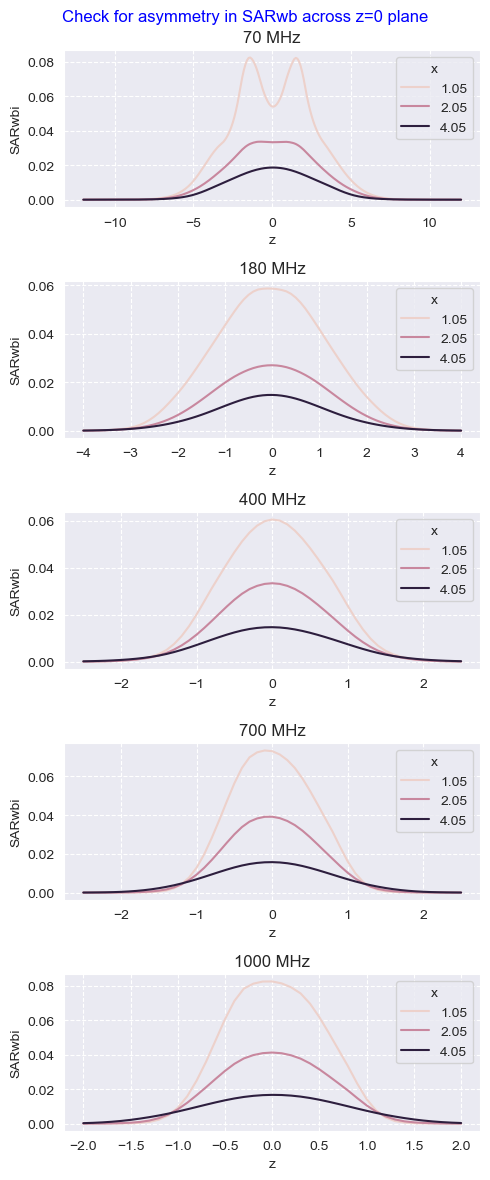

In [354]:
# Bar plots of dB(SARwb) along z for various values of x and y
SARdfi = SARdfi_all.copy()
SARdfi['dB(SARwbi)'] = dB(SARdfi.SARwbi)
xvals = [1.05,2.05,4.05]

fig, ax = plt.subplots(len(TRIALS),1,figsize=(5,12))
plt.suptitle(f"Check for asymmetry in SARwb across z=0 plane",fontsize=12,c='b')

for i, trial in enumerate(TRIALS):
    mask = (SARdfi.x.isin(xvals)) & (SARdfi.trial==trial)
    t = trialdata[trial]
    sns.lineplot(SARdfi[mask],x='z',y='SARwbi',hue='x',ax=ax[i])
    ax[i].set_title(f'{t.fMHz} MHz')
    ax[i].grid(ls='--')
    
plt.tight_layout();

Data looks nicely symmetric in the z axis, except very close to the antenna. It is *not* expected to be perfectly symmetric since the body phantom is not totally symmetric in the z direction

### Sall: Merge S with SARdfi_all
*Don't* merge in **SARdfall** since some of the SARwb points, e.g. y=0.36, x=0.81, are not on the 0.1m grid spacing

In [355]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdfi_all,how='left',on=['trial','x','y','z']).sort_values(['trial','x','y','z'],ignore_index=True)
Sall.head()

,trial,fMHz,x,y,z,wtx,SE,SH,Smax,SARwbi
0,4,70.0,0.05,0.0,-12.0,5,0.000485,6.529958e-07,0.000485,0.000014
1,4,70.0,0.05,0.0,-11.9,5,0.000512,6.884640e-07,0.000512,0.000014
2,4,70.0,0.05,0.0,-11.8,5,0.000540,7.264836e-07,0.000540,0.000014
3,4,70.0,0.05,0.0,-11.7,5,0.000570,7.672851e-07,0.000570,0.000014
4,4,70.0,0.05,0.0,-11.6,5,0.000603,8.111243e-07,0.000603,0.000014


### Show xyz grid values of Sall

In [418]:
# Show xyz grid values for Sall
Sall.groupby('fMHz').apply(getgrid)

min    max    n  max_delta
fMHz                                  
70.0   x   0.05   5.05   51        0.1
       z -12.00  12.00  241        0.1
180.0  x   0.05   5.05   51        0.1
       z  -4.00   4.00   81        0.1
400.0  x   0.05   5.05   51        0.1
       z  -2.50   2.50   51        0.1
700.0  x   0.05   5.05   51        0.1
       z  -2.50   2.50   51        0.1
1000.0 x   0.05   4.05   41        0.1
       z  -2.00   2.00   41        0.1

## Calculate spatial averages

### Simple averages

In [357]:
# Set parameters
l, dl = 1.6, 0.1
mlist = [5,9,17]

# Set convolution vectors for 1.6m
clist = [conv_vector(l, dl, m) for m in mlist]
for m, c in zip(mlist,clist):
    print(f'{m:3d} points:\nsum{list(c.round(3))} = {sum(c)}')

# Create spatial averages for SE and Smax for clist items
print()
for Si in ['Smax', 'SE']:
    for m, c in zip(mlist,clist):
        print(f'creating {m}-point spatial averages of {Si}')
        sa_all = np.empty(0)
        for trial in TRIALS:
            mask = Sall.trial == trial
            name = f"{Si}-{l}m-{m}"
            sa = spatavg(Sall[mask], name, Si,  c)
            sa_all = np.concatenate([sa_all,sa])
        Sall[name] = sa_all

  5 points:
sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
  9 points:
sum[0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111, 0.0, 0.111] = 1.0000000000000002
 17 points:
sum[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059] = 1.0

creating 5-point spatial averages of Smax
creating 9-point spatial averages of Smax
creating 17-point spatial averages of Smax
creating 5-point spatial averages of SE
creating 9-point spatial averages of SE
creating 17-point spatial averages of SE


### Simpsons 1/3 rule

In [358]:
# Set parameters
l, dl = 1.6, 0.1
mlist = [5,9,17]

# Set convolution vectors for 1.6m and Simpsons 1/3 rule
c5S13  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
c9S13  = [1,0,4,0,2,0,4,0,2,0,4,0,2,0,4,0,1]
c17S13 = [1,4,2,4,2,4,2,4,2,4,2,4,2,4,2,4,1]
clistS13 = [np.array(c) / sum(c) for c in (c5S13, c9S13, c17S13)]
for m, c in zip(mlist,clistS13):
    print(f'{m:3d} points:\nsum{list(c.round(3))} = {sum(c)}')

# Create spatial averages for SE and Smax clistS13 items
for Si in ['Smax', 'SE']:
    for m, c in zip(mlist,clistS13):
        print(f'creating {m}-point S13 spatial averages of {Si}')
        sa_all = np.empty(0)
        for trial in TRIALS:
            mask = Sall.trial == trial
            name = f"{Si}-{l}m-{m}-S13"
            sa = spatavg(Sall[mask], name, Si,  c)
            sa_all = np.concatenate([sa_all,sa])
        Sall[name] = sa_all

  5 points:
sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
  9 points:
sum[0.042, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.083, 0.0, 0.167, 0.0, 0.042] = 0.9999999999999999
 17 points:
sum[0.021, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.021] = 1.0
creating 5-point S13 spatial averages of Smax
creating 9-point S13 spatial averages of Smax
creating 17-point S13 spatial averages of Smax
creating 5-point S13 spatial averages of SE
creating 9-point S13 spatial averages of SE
creating 17-point S13 spatial averages of SE


### Gaussian Quadrature

In [359]:
# Set convolution vectors for 1.6m and Gaussian Quadrature
L = 1.6
mlist = (3,4,5,6,7)
clistGQ = [GQRpoints(m, L) for m in mlist]

# Create spatial averages for SE and Smax Gaussian quadrature
for Si in ['Smax', 'SE']:
    for m, (pts,wts) in zip(mlist,clistGQ):
        print(f'creating {m}-point GQ spatial averages of {Si}')
        sa_all = np.empty(0)
        for trial in TRIALS:
            SGQ = Sall[Sall.trial == trial]
            name = f"{Si}-{l}m-{m}-GQ"
            for xname, g in SGQ.groupby('x'):
                sa = GQRsa(pts,wts,g.z.values,g[Si].values,g.z.values)
                sa_all = np.concatenate([sa_all,sa])
        Sall[name] = sa_all

creating 3-point GQ spatial averages of Smax
creating 4-point GQ spatial averages of Smax
creating 5-point GQ spatial averages of Smax
creating 6-point GQ spatial averages of Smax
creating 7-point GQ spatial averages of Smax
creating 3-point GQ spatial averages of SE
creating 4-point GQ spatial averages of SE
creating 5-point GQ spatial averages of SE
creating 6-point GQ spatial averages of SE
creating 7-point GQ spatial averages of SE


## R, compliance ratios

$R$ is the ratio of the limit-normalized S exposure relative to the limit-normalized WBA SAR:

$\Large R = \frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}\; \; \; \; \; \; \; (Eq. 1)$

$R$ essentially indicates the level of over-estimating WBA SAR compliance when applying S limits.

Note that $R \geq 1 \Rightarrow$ WBA SAR is compliant if S is compliant

### Create R columns

In [360]:
# create data columns for compliance ratio in Sall
Silist = ['Smax','Smax-1.6m-17-S13',
          'Smax-1.6m-5','Smax-1.6m-5-S13',
          'Smax-1.6m-5-GQ','Smax-1.6m-7-GQ']
for trial in TRIALS:
    t = trialdata[trial]
    limSpub = Slimit(t.fMHz, setting='pub', standard='RPS S-1 WB')
    limSARpub = SARlimit(setting='pub')
    mask = (Sall.trial==trial)
    for Si in Silist:
        # calculate R
        R = (Sall.loc[mask,Si]/limSpub) / (Sall.loc[mask,'SARwbi']/limSARpub)
        # create R column for Si
        Rname = f'R_{Si}' 
        Sall.loc[mask,Rname] = R
        # create dB(R) column for Si
        dBRname = f'dBR_{Si}' 
        Sall.loc[mask,dBRname] = dB(R)       

## err, spatial averaging error
The `Smax-1.6m-17-S13` spatial averaging scheme is taken as the benchmark for a 'near-perfect' spatial average

$err = \frac{S_{sa}}{Smax-1.6m-17-S13}$

### Create err and dBerr columns

In [361]:
# create data columns for dB(err) in Sall
Silist = ['Smax','Smax-1.6m-17-S13',
          'Smax-1.6m-5','Smax-1.6m-5-S13',
          'Smax-1.6m-5-GQ','Smax-1.6m-7-GQ']
for Si in Silist:
    errname = f'dBerr_{Si}' 
    Sall[errname] = dB(Sall[Si] / Sall['Smax-1.6m-17-S13'])

Sall[['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','dBerr_Smax','dBerr_Smax-1.6m-5']].head()

,Smax,Smax-1.6m-5,Smax-1.6m-5-S13,dBerr_Smax,dBerr_Smax-1.6m-5
0,0.000485,0.000370,0.000345,1.879398,0.697513
1,0.000512,0.000391,0.000365,1.365072,0.202253
2,0.000540,0.000415,0.000387,1.133436,-0.009590
3,0.000570,0.000440,0.000410,0.737539,-0.384929
4,0.000603,0.000565,0.000597,0.555780,0.273480


## Sall2: Remove outer z layers
We want to remove rows in `Sall` where the spatial average values were calculated using **extrapolated** values of `Smax` or `SE`.

This occurs for those values which are within half the spatial averaging length (L/2) of the top or bottom z layers, i.e. where:

+ z > zmax - L/2
+ z < zmin + L/2

In [362]:
def remove_outer_z_values(df, trials, L):
    '''Remove rows in df where:
         z > zmax - L/2
         z < zmin + L/2
       This removes rows where the spatial average values were calculated on 
       extrapolated values of Smax or SE
       INPUTS:
         df = S dataframe from which rows are being removed
         trials = list of trial numbers in df
         L = spatial averaging length
    '''
    for trial in trials:
        mask_trial = (df.trial == trial)
        dftz = df.loc[mask_trial,'z']
        zmin = dftz.min()
        zmax = dftz.max()
        mask_zlow  = (df.z < zmin + L/2)
        mask_zhigh = (df.z > zmax - L/2)    
        mask_outers = mask_trial & (mask_zlow | mask_zhigh)
        # display(df[mask_outers])
        df = df[~mask_outers]
    return df

Sall2 = remove_outer_z_values(Sall, TRIALS, L=1.6);

In [363]:
# Check grid values of Sall2
Sall2.groupby('fMHz').apply(getgrid)

min    max    n  max_delta
fMHz                                  
70.0   x   0.05   5.05   51        0.1
       z -11.20  11.20  225        0.1
180.0  x   0.05   5.05   51        0.1
       z  -3.20   3.20   65        0.1
400.0  x   0.05   5.05   51        0.1
       z  -1.70   1.70   35        0.1
700.0  x   0.05   5.05   51        0.1
       z  -1.70   1.70   35        0.1
1000.0 x   0.05   4.05   41        0.1
       z  -1.20   1.20   25        0.1

## SallR: Retain points b/w compliance boundaries
We want to only retain rows in `Sall2` where the assessment point lies between the occupational and public compliance boundaries for antenna powers **25W** to **200W**.

We convert dataframe to long format for easy plotting with seaborn.

In [364]:
## Convert Sall to long format
id_vars = ['fMHz','x','z','wtx']
value_vars = Sall2.loc[:,'SE':].columns.tolist()
df = Sall2.melt(id_vars=id_vars, value_vars=value_vars,
                var_name='metric',value_name='value',ignore_index=True)
metrics = df.metric.unique()  # array of metrics in df

# Set parameters
Silist = Sall2.loc[:,'SE':'SE-1.6m-7-GQ'].columns.tolist()
lowp, highp = 0.5, 2   # fractions of nominal 100W power

# Retain only points between compliance boundaries
ix = []   # index of retained rows in df
for fMHz in freqs:
    # Set S values fo low and high compliance boundaries
    limSpub = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
    limSocc = Slimit(fMHz, setting='occ', standard='RPS S-1 WB')
    Slow = limSpub / highp
    Shigh = limSocc / lowp
    
    for Si in Silist:
        # Get retention mask for fMHz-Si block
        df_fMHz_Si = df[(df.fMHz == fMHz) & (df.metric == Si)]
        mask_retain = (df_fMHz_Si.value > Slow) & (df_fMHz_Si.value < Shigh)
        mask_retain = mask_retain.values  # remove index to avoid index alignment with df_fMHz_metric
        
        # Create list of metrics relating to Si
        Si_like = [Si, 'R_' + Si, 'dBR_' + Si, 'dBerr_' + Si]
        # print(f'{fMHz:4} MHz, {Si=}', Si_like)
        
        for metric in Si_like:
            if metric in metrics:
                df_fMHz_metric = df[(df.fMHz == fMHz) & (df.metric == metric)]
                # print(f'  {metric=}, {len(mask_retain)=}, {len(df_fMHz_metric)=}')
                df_fMHz_metric = df_fMHz_metric[mask_retain]
                ixa = df_fMHz_metric.index
                ix = np.append(ix,ixa)

ix_retain = ix.astype(int)
SallR = df.loc[ix_retain]

In [365]:
SallR.metric.unique()

array(['SE', 'SH', 'Smax', 'R_Smax', 'dBR_Smax', 'dBerr_Smax',
       'Smax-1.6m-5', 'R_Smax-1.6m-5', 'dBR_Smax-1.6m-5',
       'dBerr_Smax-1.6m-5', 'Smax-1.6m-9', 'Smax-1.6m-17', 'SE-1.6m-5',
       'SE-1.6m-9', 'SE-1.6m-17', 'Smax-1.6m-5-S13', 'R_Smax-1.6m-5-S13',
       'dBR_Smax-1.6m-5-S13', 'dBerr_Smax-1.6m-5-S13', 'Smax-1.6m-9-S13',
       'Smax-1.6m-17-S13', 'R_Smax-1.6m-17-S13', 'dBR_Smax-1.6m-17-S13',
       'dBerr_Smax-1.6m-17-S13', 'SE-1.6m-5-S13', 'SE-1.6m-9-S13',
       'SE-1.6m-17-S13', 'Smax-1.6m-3-GQ', 'Smax-1.6m-4-GQ',
       'Smax-1.6m-5-GQ', 'R_Smax-1.6m-5-GQ', 'dBR_Smax-1.6m-5-GQ',
       'dBerr_Smax-1.6m-5-GQ', 'Smax-1.6m-6-GQ', 'Smax-1.6m-7-GQ',
       'R_Smax-1.6m-7-GQ', 'dBR_Smax-1.6m-7-GQ', 'dBerr_Smax-1.6m-7-GQ',
       'SE-1.6m-3-GQ', 'SE-1.6m-4-GQ', 'SE-1.6m-5-GQ', 'SE-1.6m-6-GQ',
       'SE-1.6m-7-GQ', 'SARwbi'], dtype=object)

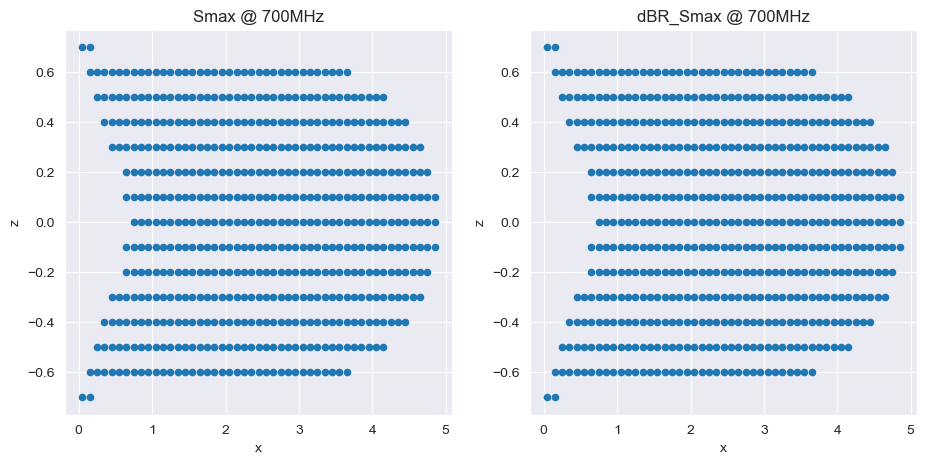

In [366]:
# Check 
fig, ax = plt.subplots(1,2,figsize=(11,5))
Si = 'Smax-1.6m-5-GQ'
Si = 'Smax'
fMHz = 700

Silist = [Si, 'dBR_'+Si]
for i, Si in enumerate(Silist):
    mask = (SallR.fMHz == fMHz) & (SallR.metric == Si) 
    SallR[mask].plot.scatter('x','z',ax=ax[i],title=f'{Si} @ {fMHz}MHz');

## Check whole body SAR values

### Plot SARwbi values

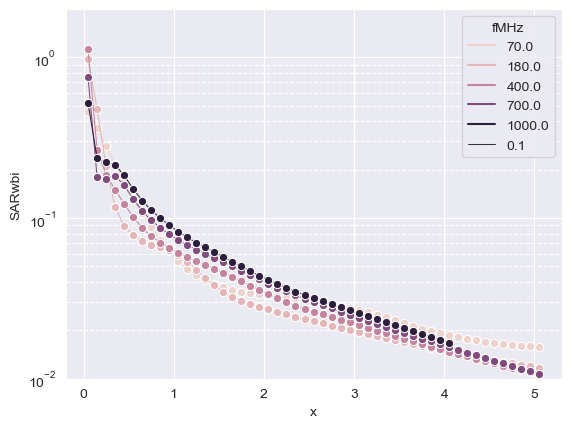

In [416]:
mask = Sall2.z==0
sns.lineplot(data=Sall2[mask],x='x',y='SARwbi',marker='o',
            size=0.1,hue='fMHz')
plt.grid(ls='--',which='minor')
plt.yscale("log")
plt.ylim(0.01,2);

### Single IEC SAR formula check

In [413]:
d = 1  # x distance of body to antenna
body = 'adult'
fMHz = 400
P = 100      # radiated antenna power
N = 4        # No. of driven elements in antenna
DdBi = 7.4   # peak directivity of the antenna (dBi)
L = omni_length(fMHz)  # length of antenna
Φdeg = 360   # horizontal half-power beamwidth (degrees) of the antenna
Θdeg = 18    # vertical half-power beam width (degrees) of the antenna

SARwb = SAR_IEC_front(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)[0]
print(f'SARwb = {SARwb:0.3f} W/kg')

SARwb = 0.037 W/kg


In [409]:
# Print omni antenna lengths for all frequencies
print('fMHz   L (m)')
for fMHz in FREQS:
    L = omni_length(fMHz)
    print(f'{fMHz:5g}  {L:0.2f}')

fMHz   L (m)
   70  18.21
  180  7.08
  400  3.19
  700  1.82
 1000  1.27


### Multiple IEC SAR formula checks (400,700,1000 MHz)

In [410]:
# Create dfSAR dataframe
mask = (Sall2.z == 0) & (Sall2.fMHz.isin([400,700,1000]))
dfSAR = Sall2.loc[mask,['fMHz','x','SARwbi']].dropna().copy()
dfSAR = dfSAR.rename(columns={'SARwbi':'SAR_FEKO'})

# Vectorize the SAR_IEC_front and omni_length functions
SAR_IEC_front_vec = np.vectorize(SAR_IEC_front)
omni_length_vec = np.vectorize(omni_length)

# Calculate IEC SAR
d = dfSAR.x.values
fMHz = dfSAR.fMHz.values
L = omni_length_vec(fMHz)
dfSAR['L'] = L
dfSAR['SAR_IEC'] = SAR_IEC_front_vec(d,body,fMHz,P,N,DdBi,L,Φdeg,Θdeg)[0]

# Calculate ratio of SAR_FEKO / SAR_IEC
dfSAR['ratio'] = (dfSAR.SAR_FEKO / dfSAR.SAR_IEC).round(3)

dfSAR.head()

,fMHz,x,SAR_FEKO,L,SAR_IEC,ratio
16447,400.0,0.05,1.121700,3.1875,NaN,NaN
16498,400.0,0.15,0.265433,3.1875,NaN,NaN
16549,400.0,0.25,0.185024,3.1875,0.123375,1.500
16600,400.0,0.35,0.150574,3.1875,0.099836,1.508
16651,400.0,0.45,0.122612,3.1875,0.082175,1.492


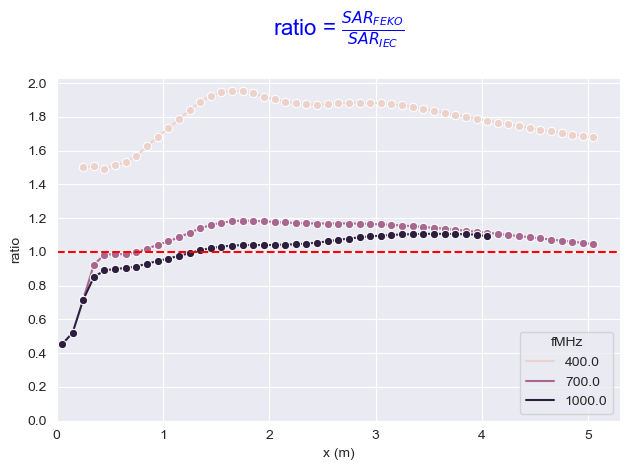

In [411]:
# Plot SAR ratio
title = r'ratio = $\frac{SAR_{FEKO}}{SAR_{IEC}}$' + '\n'
g = sns.lineplot(data=dfSAR,x='x',y='ratio',marker='o',
               hue='fMHz')
plt.ylim(0, None)
plt.xlim(0,None)
plt.axhline(1,color='red',ls='--')
plt.xlabel('x (m)')
plt.yticks(np.arange(0,2.2,0.2))
plt.title(title,color='blue',fontsize=16)
plt.tight_layout()
plt.savefig(PLOTDIR+f'SAR ratio vs x scatterlot.png',dpi=200)

## Draw plots

### Compliance boundary plots

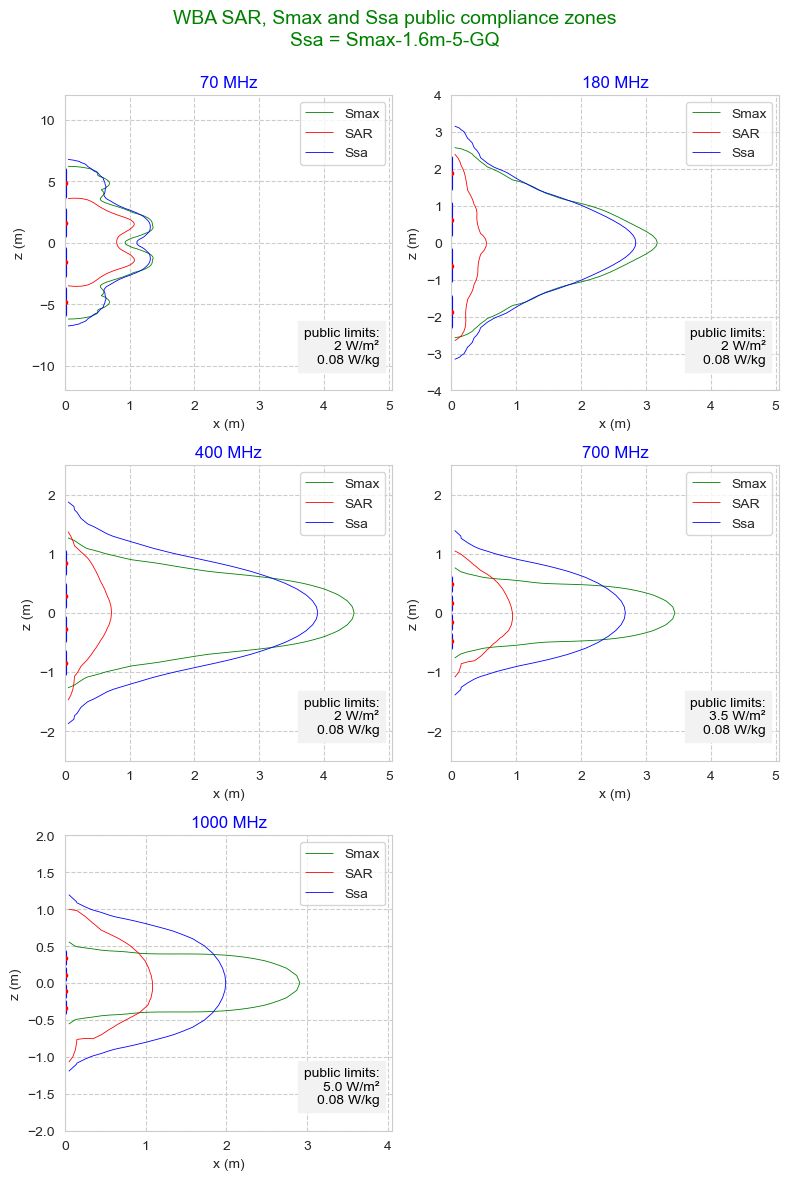

In [371]:
# Plot settings
Ssa = 'Smax-1.6m-5-GQ'
setting = 'public'
rows, cols = 3, 2

# Plot compliance boundaries
sns.set_style("whitegrid")
fig, axes = plt.subplots(rows,cols,figsize=(8,12))
for i, trial in enumerate(TRIALS):
    t = trialdata[trial]
    mask = (Sall.trial == trial)
    complot(Sall[mask],t,setting,Ssa=Ssa,axes=axes,axi=i)

# Finish off figure
axes[2,1].remove()
plot_title = f"WBA SAR, Smax and Ssa {setting} compliance zones\nSsa = {Ssa}\n"
fig.suptitle(plot_title, color='green', fontsize=14)
fig.tight_layout()
fig.savefig(PLOTDIR + f'PD620 complot {Ssa}.png',dpi=200)


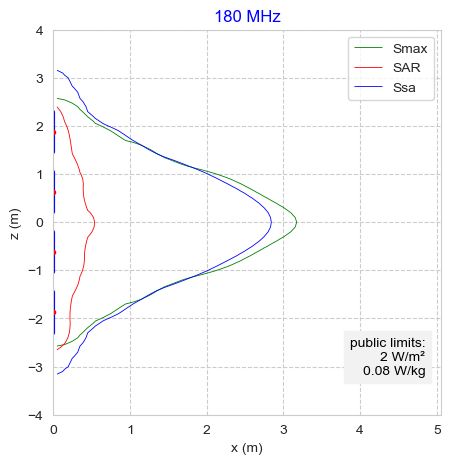

In [372]:
trial = 5  # 180 MHz
t = trialdata[trial]
mask = (Sall.trial == trial)
complot(Sall[mask],t,setting,Ssa=Ssa,figsize=(5,5))

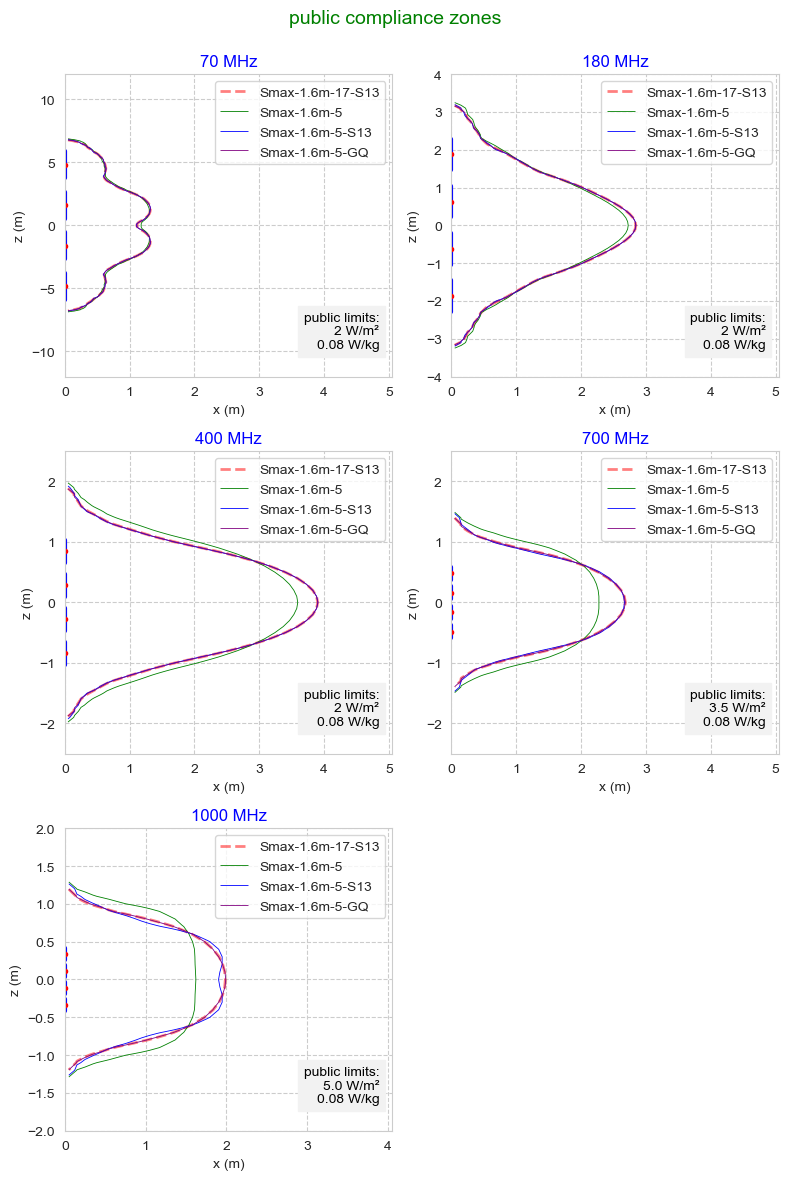

In [373]:
# Plot settings
Scols = ['Smax-1.6m-17-S13','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ']
setting = 'public'
rows, cols = 3, 2

# Plot compliance boundaries
sns.set_style("whitegrid")
fig, axes = plt.subplots(rows,cols,figsize=(8,12))
for i, trial in enumerate(TRIALS):
    t = trialdata[trial]
    mask = (Sall.trial == trial)
    complot2(Sall[mask],t,setting,Scols=Scols,axes=axes,axi=i)

# Finish off figure
axes[2,1].remove()
plot_title = f"{setting} compliance zones\n"
fig.suptitle(plot_title, color='green', fontsize=14)
fig.tight_layout()
fig.savefig(PLOTDIR + f'PD620 complot compare Ssa.png',dpi=200)


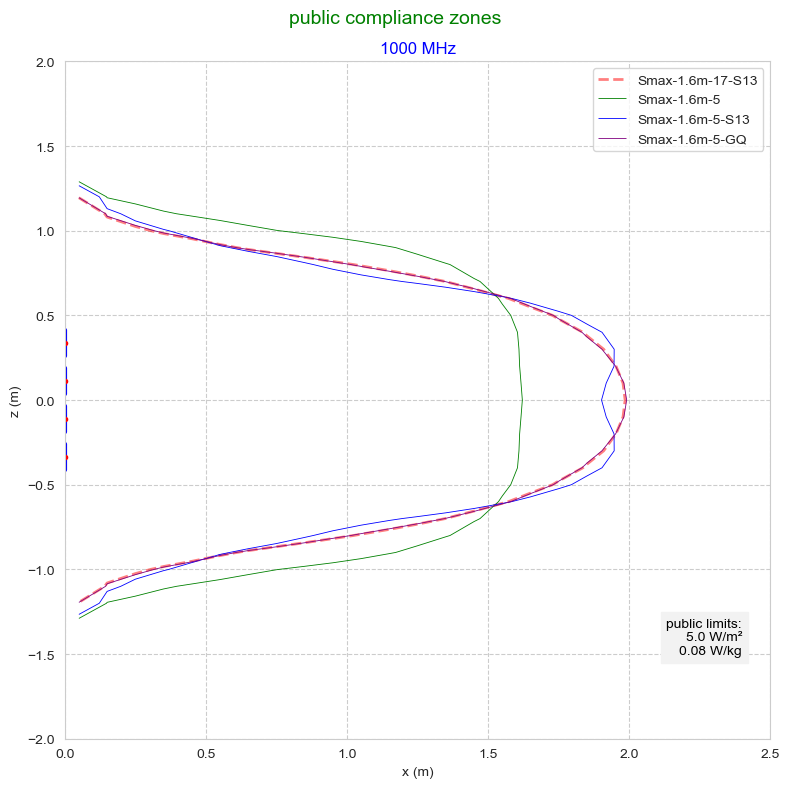

In [374]:
# Plot settings
trial = 8
Scols = ['Smax-1.6m-17-S13','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ']
setting = 'public'

# Plot compliance boundaries
sns.set_style("whitegrid")
t = trialdata[trial]
mask = (Sall.trial == trial)
complot2(Sall[mask],t,setting,Scols=Scols,figsize=(8,8))   

# Finish off figure
plt.xlim(0,2.5)
plot_title = f"{setting} compliance zones"
plt.suptitle(plot_title, color='green', fontsize=14)
plt.tight_layout()
plt.savefig(PLOTDIR + f'PD620 complot compare Ssa 1000MHz.png',dpi=200)


### Check Ssa convergence at 1000 MHz

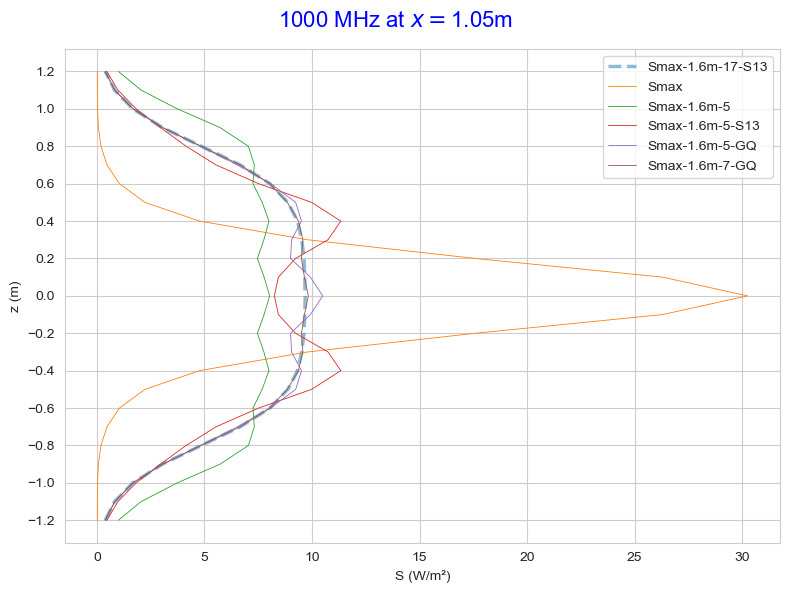

In [375]:
# Compare Ssa levels at x=1.05m at 1000 MHz
fMHz = 1000
xp = 1.05
Ssa = ['Smax-1.6m-17-S13','Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ','Smax-1.6m-7-GQ']
# Ssa = ['Smax','Smax-1.6m-17-S13','Smax-1.6m-5-S13','Smax-1.6m-5-GQ']

mask = (Sall2.fMHz==fMHz) & (Sall2.x == xp)
SGC = Sall2[mask]
zsa = SGC.z.values[8:-8]

fig,ax = plt.subplots(figsize=(8,6))
for Si in Ssa:
    if Si=='Smax-1.6m-17-S13':
        lw,alpha,ls = 2.5,0.5,'--'
    else:
        lw,alpha,ls = 0.6,1.0,'-'
    SGC.plot(Si,'z',ax=ax,label=Si,lw=lw,ls=ls,alpha=alpha)
plt.yticks(np.arange(-1.2,1.4,0.2))
ax.set_xlabel('S (W/m²)');
ax.set_ylabel('z (m)');
fig.suptitle(f'{fMHz} MHz at $x=${xp}m',fontsize=16,color='blue')
fig.tight_layout()
plt.savefig(PLOTDIR + f'PD620 compare Ssa x={xp} 1000MHz.png',dpi=200)

### Smax vertical plots

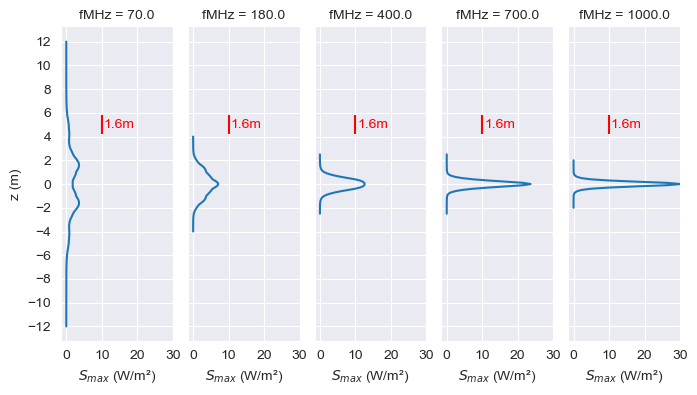

In [376]:
mask = (S.x == 1.05)
sns.set_style("darkgrid")
g = sns.relplot(S[mask],x="Smax",y="z",col="fMHz",
                kind="line",height=4, aspect=0.35,sort=False)
for ax in g.axes.flatten():
    ax.vlines(x=10,ymin=5-0.8,ymax=5+0.8,color='red')
    ax.text(10.5,5,'1.6m',color='red',va='center',ha='left')

g.set(xlim=(None,30),
      xticks=(range(0,40,10)),yticks=range(-12,14,2),
      ylabel="z (m)",xlabel="$S_{max}$ (W/m²)")
plt.savefig(PLOTDIR+'Smax unifomity over z.png',dpi=200)

### dBR sampling points

In [377]:
metric = 'dBR_Smax'
mask = (SallR.metric==metric)

alt.Chart(SallR[mask]).mark_circle(size=7).encode(
    x='x',
    y='z',
    color=alt.Color("value:Q", title='dB(R)')\
             .scale(scheme='redyellowblue',domain=[-8,8],bins=np.arange(-8,12,2)),
    tooltip=['x', 'z', 'value'],
    facet=alt.Facet('fMHz:O', columns=2),
).properties(
    width=220,
    height=220,
    title='dB(R) for Smax'
).interactive()

alt.Chart(...)

Text(0.5, 0.98, 'R assessment points for dBR_Smax and antenna power 50 to 200 W')

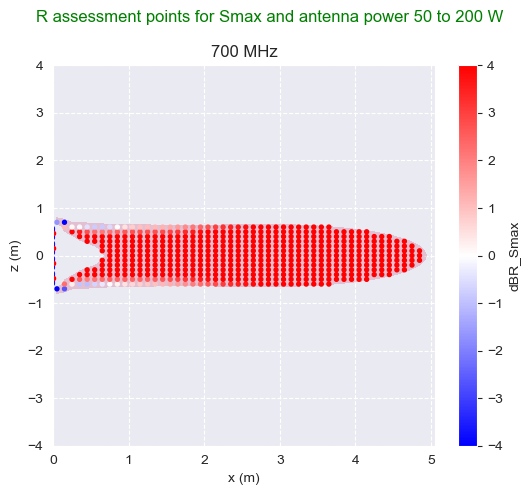

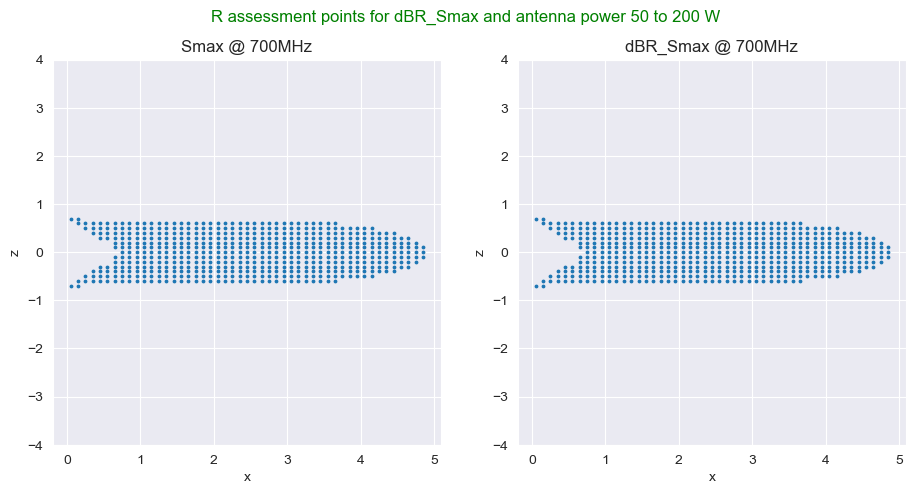

In [378]:
Si = 'Smax'
fMHz = 700

fig1, ax1 = plt.subplots(figsize=(5.5,5))
Rpoints(ax1,Sall2,Si,fMHz,POWER_LOW,POWER_HIGH,True,8)
ax1.set_ylim(-4,4)
fig1.suptitle(f"R assessment points for {Si} and antenna power {POWER_LOW*POWER:g} to {POWER_HIGH*POWER} W",
             color='g')
fig1.tight_layout()
# plt.savefig(PLOTDIR+f'dBR points for {Si} {fMHz}MHz.png',dpi=200)

# Check against values in SallR
fig2, ax2 = plt.subplots(1,2,figsize=(11,5))
Silist = [Si, 'dBR_'+Si]
for i, Si in enumerate(Silist):
    mask = (SallR.fMHz == fMHz) & (SallR.metric == Si) 
    SallR[mask].plot.scatter('x','z',s=3,ax=ax2[i],title=f'{Si} @ {fMHz}MHz')
    ax2[i].set_ylim(-4,4)
fig2.suptitle(f"R assessment points for {Si} and antenna power {POWER_LOW*POWER:g} to {POWER_HIGH*POWER} W",
             color='g')

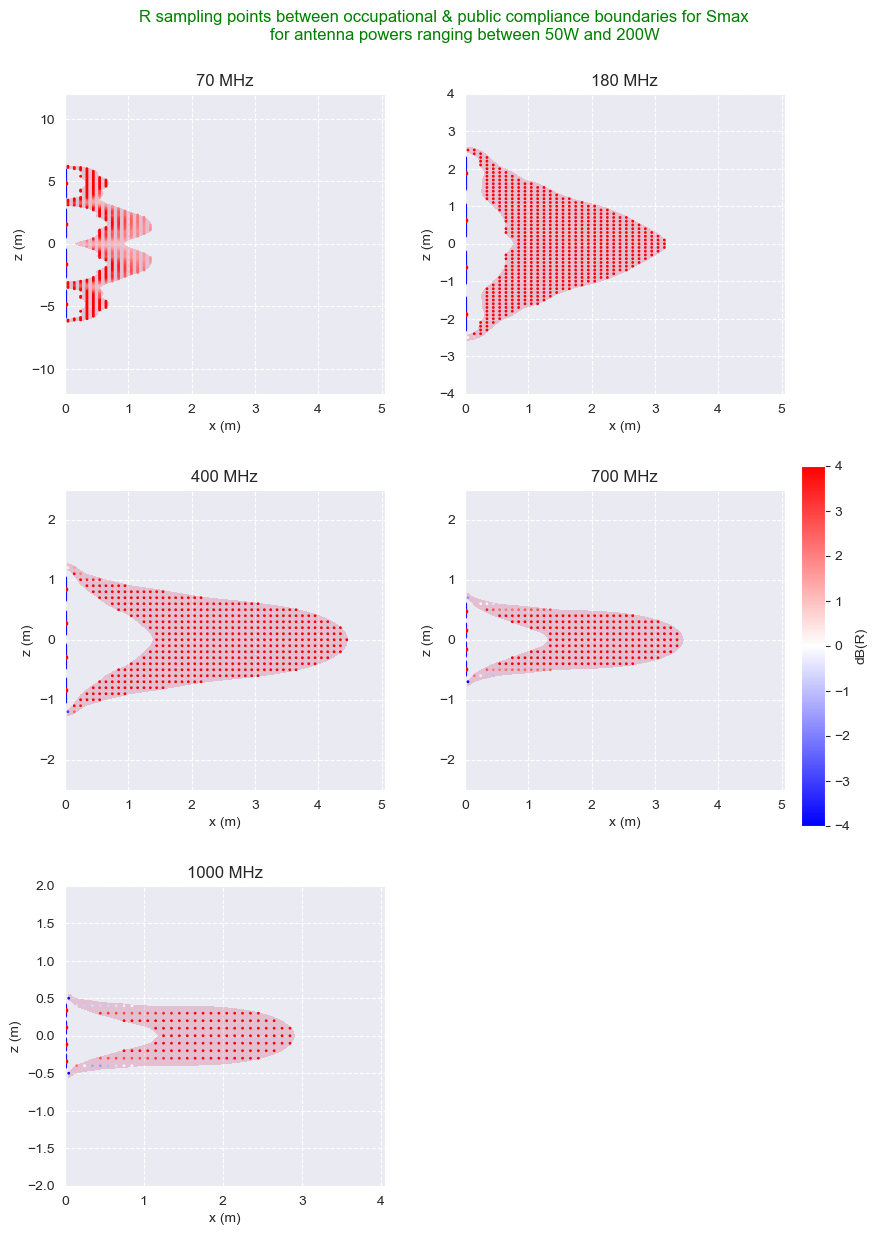

In [379]:
Si = 'Smax'
# Si = 'Smax-1.6m-5-S13'

# Generate axes
fig = plt.figure(figsize=(8,12))
axes = []
width = 0.4
height = 0.25
for bottom in [0.66,0.33,0]:
    for left in [0,0.5]:
        axes.append(fig.add_axes([left,bottom,width,height]))
axes[-1].remove()
axcb = fig.add_axes([0.92,0.3,0.03,0.3])

# Generate plots
for i, fMHz in enumerate(freqs):
    # Rpoints(axes[i],Sall,Si,fMHz,POWER_LOW,POWER_HIGH)
    Rpoints(axes[i],Sall,Si,fMHz,1,1)
    
# colorbar
cmap = mpl.cm.bwr
norm = mpl.colors.Normalize(vmin=-4, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(axcb, cmap=cmap,
                                norm=norm,label='dB(R)',
                                orientation='vertical')
# Set title
title = f'R sampling points between occupational & public compliance boundaries for {Si} \
        \nfor antenna powers ranging between {POWER*POWER_LOW:g}W and {POWER*POWER_HIGH:g}W'
fig.suptitle(title,color='g',fontsize=12)

fig.tight_layout()
plt.savefig(PLOTDIR+f'dBR points for {Si}.png',dpi=200)

### R histograms

#### Single case (weighted) for pts b/w compliance boundaries

70 MHz: S limit = 2 W/m², SAR limit = 0.08 W/kg
1564


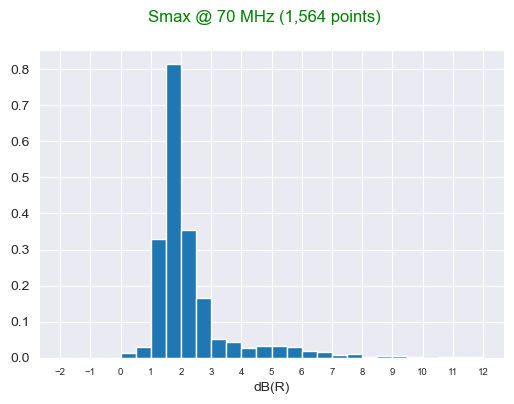

In [380]:
# Set parameters
fMHz = 70
Si = "Smax"
Ri = "dBR_" + Si

# Calculate limit values
limSpub = Slimit(fMHz, setting='pub', standard='RPS S-1 WB')
limSocc = Slimit(fMHz, setting='occ', standard='RPS S-1 WB')
print(f'{fMHz} MHz: S limit = {limSpub} W/m², SAR limit = {limSARpub} W/kg')

# set mask for trial
mask = (Sall2.fMHz == fMHz) & \
       (Sall2[Si] >= limSpub*POWER_LOW) & \
       (Sall2[Si] <= limSocc*POWER_HIGH)
print(sum(mask))

# Create figure
fig, ax = plt.subplots(1,1,figsize=(6,4))
bins = np.arange(-2,12.5,0.5)

# Plot histogram 1
ax.hist(Sall2.loc[mask,Ri], bins=bins, density=True,
        weights=Sall2.loc[mask,'wtx'])
ax.set_xticks(ticks=bins)
plt.xticks(range(-2,13,1),fontsize=7)
ax.set_xlabel('dB(R)')
fig.suptitle(f'{Si} @ {fMHz} MHz ({sum(mask):,g} points)',color='g');

#### dB(R) histogram function

In [422]:
def dBR_hist(df,fMHz_list,Si_list,bins,figsize,xticks=None):
    '''Generate histogram plots of dB(R) for the values
       specified in fMHz_list & Si_list
       INPUTS:
         df = dataframe of data points between compliance boundaries
              in long format (i.e., SallR)
         fMHz_list = list of frequencies to be plotted
         Si_list = list of spatial average options
         bins = histogram bins
         figsize = tuple for figures size (width, height) in inches
         xticks = xtick lables for the plots
         '''
    # Create the figure
    nrows = len(Si_list)
    ncols = len(fMHz_list)
    fig, axes = plt.subplots(nrows,ncols,figsize=figsize,
                             sharex=True,sharey=True)

    # Plot the histograms
    for i, fMHz in enumerate(fMHz_list):
        for j, Si in enumerate(Si_list):
            # mask = cbmask(df, Si, fMHz, lowp, highp)
            ax = axes[j,i]
            dBRSi = 'dBR_' + Si
            mask = (df.fMHz == fMHz) & (df.metric == dBRSi)
            data = df.loc[mask,'value'].values
            wtx = df.loc[mask,'wtx'].values
            data_wtx = np.repeat(data, wtx)
            ax.hist(data_wtx,bins=bins,density=True)
            CI95 = np.percentile(data_wtx,[2.5,97.5]).round(1)
            mean_wtx = data_wtx.mean().round(1)
            ax.set_xlim(bins.min(),bins.max())
            ax.axvline(0,color='red',ls='--')
            title = f'{fMHz} (MHz)' if j == 0 else ''
            ax.set_title(title, fontsize=12,color='green')
            CItext = f'95% CI:\n{CI95[0]} to {CI95[1]} dB\nµ = {mean_wtx} dB\n{sum(mask):,g} points'
            ax.text(0.2, 0.96, CItext,fontsize=8,color='navy',
                    horizontalalignment='left',verticalalignment='top',
                    transform=ax.transAxes)
            if xticks != None: ax.set_xticks(xticks)
            if i%nrows == 0: ax.set_ylabel("Probability density")
            if j == nrows-1: ax.set_xlabel("dB(R)")
            if i == ncols-1:
                ax.text(1.05, 0.5, Si, horizontalalignment='center',color='g',
                        rotation=-90,verticalalignment='center', fontsize=12,
                        transform=ax.transAxes)
    fig.suptitle('dB(R) histograms for points between compliance boundaries\nweighted by x\n',
                 color='black', fontsize=14)
    fig.tight_layout()                
    plt.savefig(PLOTDIR+f'dBR histograms for {fMHz_list}.png',dpi=200)

#### 70, 180, 400 MHz

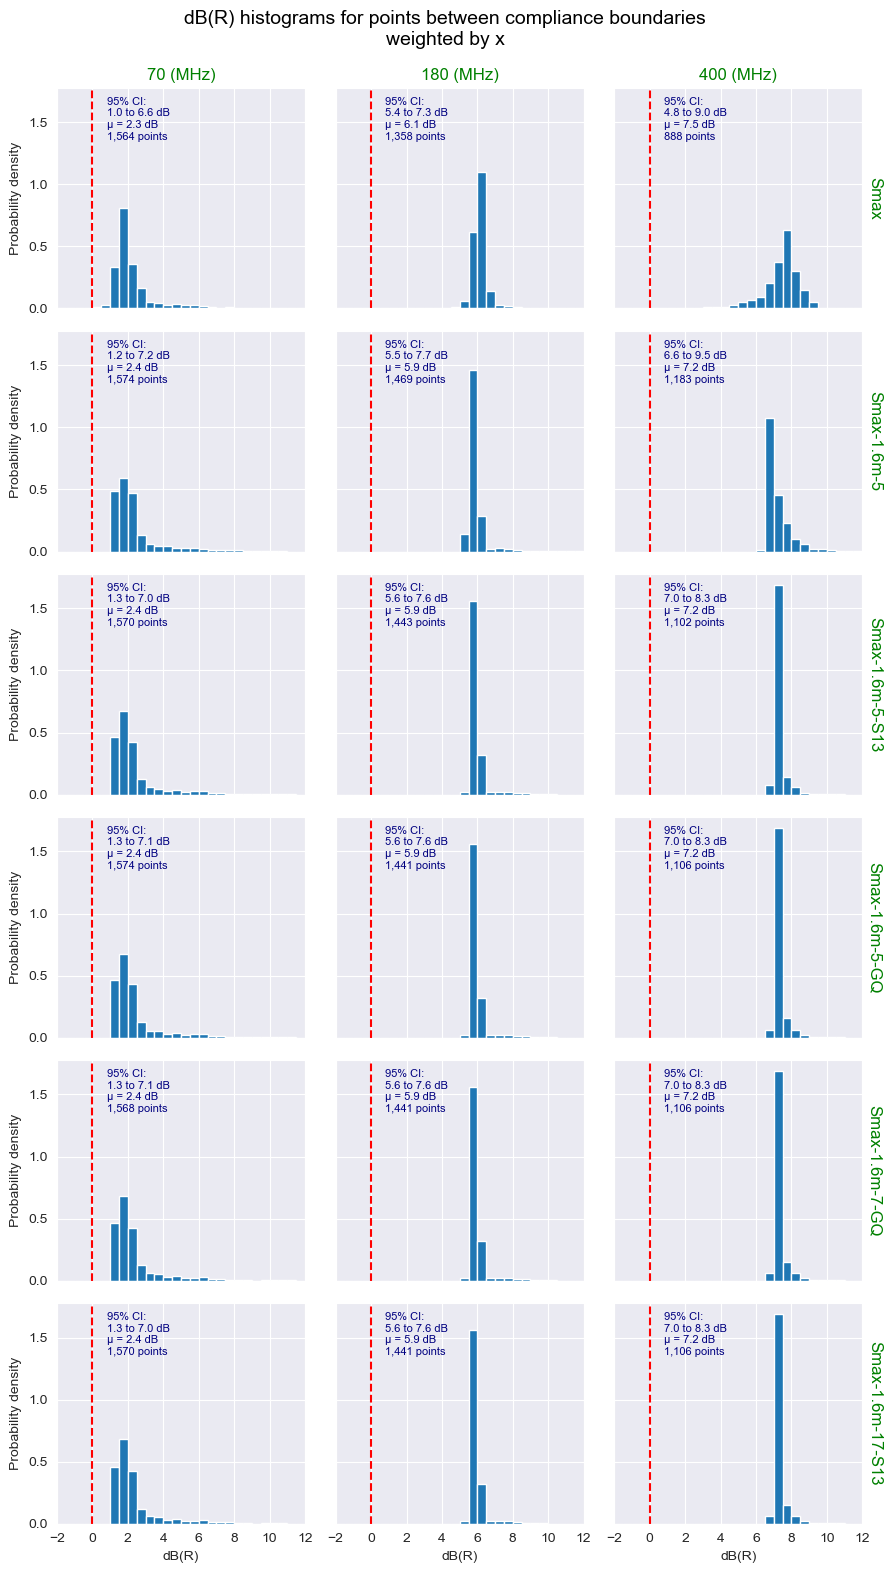

In [423]:
fMHz_list = [70,180,400]
Si_list = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ','Smax-1.6m-7-GQ','Smax-1.6m-17-S13']
df = SallR
bins = np.arange(-2,12.5,0.5)
xticks = range(-2,14,2)
dBR_hist(SallR,fMHz_list,Si_list,bins,figsize=(9,16),xticks=xticks)

#### 700, 1000 MHz

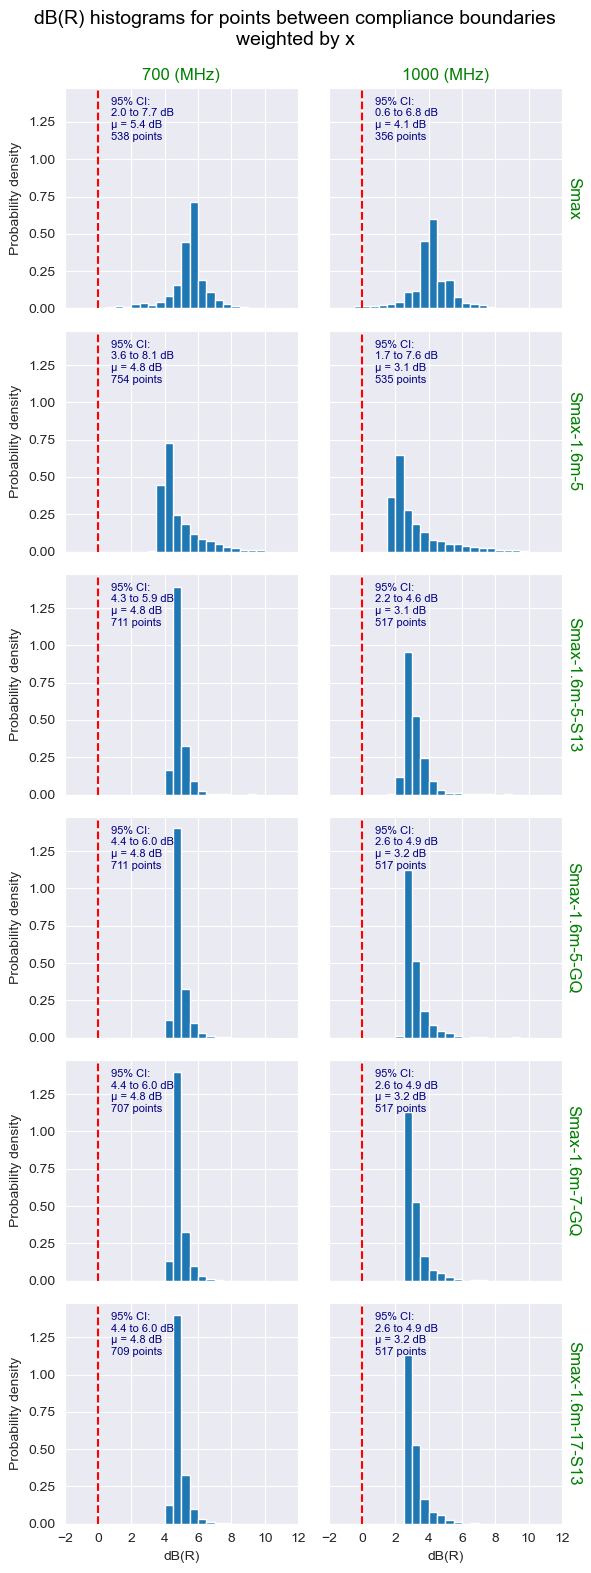

In [424]:
fMHz_list = [700,1000]
Si_list = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ','Smax-1.6m-7-GQ','Smax-1.6m-17-S13']
df = SallR
bins = np.arange(-2,10.5,0.5)
xticks = range(-2,14,2)
dBR_hist(SallR,fMHz_list,Si_list,bins,figsize=(6,16),xticks=xticks)

In [440]:
def CI95(arr):
    ci95 = np.percentile(arr, [2.5,97.5])
    return f'{ci95[0]:0.1f} to {ci95[1]:0.1f}'

mask = (SallR.metric == 'dBR_Smax-1.6m-17-S13')

table_list = []
for fMHz, g in SallR[mask].groupby('fMHz'):
    data = np.repeat(g.value.values, g.wtx.values)
    m = data.mean().round(1)
    ci = CI95(data)
    table_list.append([int(fMHz), m, ci])

table = pd.DataFrame(table_list, columns=['Freq (MHz)','Mean (dB)','95% CI (dB)'])
table.set_index('Freq (MHz)')

,Mean (dB),95% CI (dB)
Freq (MHz),,
70,2.4,1.3 to 7.0
180,5.9,5.6 to 7.6
400,7.2,7.0 to 8.3
700,4.8,4.4 to 6.0
1000,3.2,2.6 to 4.9


#### Check values

In [384]:
# Check values
print('*** C95 CI for dB R values ***')
for Si in Si_list:
    dBRSi = 'dBR_' + Si
    for fMHz in fMHz_list:
        mask = (SallR.metric==dBRSi) & (SallR.fMHz==fMHz)
        data = SallR.loc[mask,'value'].values
        wtx = SallR.loc[mask,'wtx'].values
        data_wtx = np.repeat(data, wtx)
        C95 = np.percentile(data_wtx,[2.5,97.5]).round(1)
        print(f'{Si:17} {fMHz:5} MHz [{C95[0]:3.1f} to {C95[1]:4.1f}]  {len(data):5,g} points')

*** C95 CI for dB R values ***
Smax                700 MHz [2.0 to  7.7]    538 points
Smax               1000 MHz [0.6 to  6.8]    356 points
Smax-1.6m-5         700 MHz [3.6 to  8.1]    754 points
Smax-1.6m-5        1000 MHz [1.7 to  7.6]    535 points
Smax-1.6m-5-S13     700 MHz [4.3 to  5.9]    711 points
Smax-1.6m-5-S13    1000 MHz [2.2 to  4.6]    517 points
Smax-1.6m-5-GQ      700 MHz [4.4 to  6.0]    711 points
Smax-1.6m-5-GQ     1000 MHz [2.6 to  4.9]    517 points
Smax-1.6m-7-GQ      700 MHz [4.4 to  6.0]    707 points
Smax-1.6m-7-GQ     1000 MHz [2.6 to  4.9]    517 points
Smax-1.6m-17-S13    700 MHz [4.4 to  6.0]    709 points
Smax-1.6m-17-S13   1000 MHz [2.6 to  4.9]    517 points


#### Table of descriptive stats for x-weighted data

In [455]:
def showRstats(df, Si_list, fMHz_list, dB=True):
    table = []
    for fMHz in fMHz_list:
        for Si in Si_list: 
            Rcol = f'R_{Si}'
            mask = (df.metric==Rcol) & (df.fMHz==fMHz)
            data = df.loc[mask,'value'].values
            wtx = df.loc[mask,'wtx'].values
            data_wtx = np.repeat(data, wtx)
            dataname = ''
            if dB:
                data_wtx = 10. * np.log10(data_wtx)
                dataname = 'dB(R) data'
            count = len(data)
            ci = np.percentile(data_wtx,[2.5,50,97.5]).round(1)
            mean = data_wtx.mean().round(1)
            std = data_wtx.std().round(2)
            minval = data_wtx.min().round(1)
            maxval = data_wtx.max().round(1)
            table.append([fMHz,Si,count,mean,std,minval,ci[0],ci[1],ci[2],maxval])
    table = pd.DataFrame(table,columns=('fMHz','Si','count','mean','std','min','2.5%','50%','97.5%','max'))
    table = table.set_index(['fMHz','Si'])
    table.columns.name = dataname
    
    return table

fMHz_list = [70,180,400,700,1000]
Si_list = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ','Smax-1.6m-7-GQ','Smax-1.6m-17-S13']
showRstats(SallR, Si_list, fMHz_list, dB=True)

dB(R) data             count  mean   std  min  2.5%  50%  97.5%   max
fMHz Si                                                              
70   Smax               1564   2.3  1.47 -0.1   1.0  1.8    6.6  14.5
     Smax-1.6m-5        1574   2.4  1.56  1.1   1.2  1.9    7.2  14.3
     Smax-1.6m-5-S13    1570   2.4  1.53  1.0   1.3  1.9    7.0  17.5
     Smax-1.6m-5-GQ     1574   2.4  1.53  1.0   1.3  1.9    7.1  14.0
     Smax-1.6m-7-GQ     1568   2.4  1.52  1.0   1.3  1.9    7.1  14.2
     Smax-1.6m-17-S13   1570   2.4  1.52  1.0   1.3  1.9    7.0  14.1
180  Smax               1358   6.1  0.50 -2.4   5.4  6.1    7.3  11.4
     Smax-1.6m-5        1469   5.9  0.61  5.3   5.5  5.7    7.7  15.2
     Smax-1.6m-5-S13    1443   5.9  0.51  5.1   5.6  5.8    7.6  18.9
     Smax-1.6m-5-GQ     1441   5.9  0.51  5.2   5.6  5.8    7.6  13.7
     Smax-1.6m-7-GQ     1441   5.9  0.51  5.2   5.6  5.8    7.6  15.0
     Smax-1.6m-17-S13   1441   5.9  0.51  5.2   5.6  5.8    7.6  14.5
400  Smax                888   7.5  1.02 -6.6   4.8  7.7    9.0   9.7
     Smax-1.6m-5        1183   7.2  0.80  6.4   6.6  7.0    9.5  16.5
     Smax-1.6m-5-S13    1102   7.2  0.37  6.8   7.0  7.1    8.3  13.1
     Smax-1.6m-5-GQ     1106   7.2  0.38  6.9   7.0  7.1    8.3  13.3
     Smax-1.6m-7-GQ     1106   7.2  0.38  6.9   7.0  7.1    8.3  13.1
     Smax-1.6m-17-S13   1106   7.2  0.38  6.9   7.0  7.1    8.3  13.2
700  Smax                538   5.4  1.24 -5.8   2.0  5.6    7.7   8.8
     Smax-1.6m-5         754   4.8  1.24  3.5   3.6  4.3    8.1  20.9
     Smax-1.6m-5-S13     711   4.8  0.45  4.1   4.3  4.7    5.9  17.8
     Smax-1.6m-5-GQ      711   4.8  0.43  4.4   4.4  4.7    6.0  16.3
     Smax-1.6m-7-GQ      707   4.8  0.43  4.4   4.4  4.7    6.0  15.8
     Smax-1.6m-17-S13    709   4.8  0.43  4.4   4.4  4.7    6.0  15.4
1000 Smax                356   4.1  1.31 -8.5   0.6  4.1    6.8   8.3
     Smax-1.6m-5         535   3.1  1.61  1.6   1.7  2.5    7.6  15.4
     Smax-1.6m-5-S13     517   3.1  0.62  1.8   2.2  3.0    4.6  11.6
     Smax-1.6m-5-GQ      517   3.2  0.60  2.4   2.6  2.9    4.9  10.3
     Smax-1.6m-7-GQ      517   3.2  0.59  2.6   2.6  2.9    4.9   9.6
     Smax-1.6m-17-S13    517   3.2  0.59  2.6   2.6  2.9    4.9   9.5

### dB(R) vs x scatter plots

#### All points in Sall2

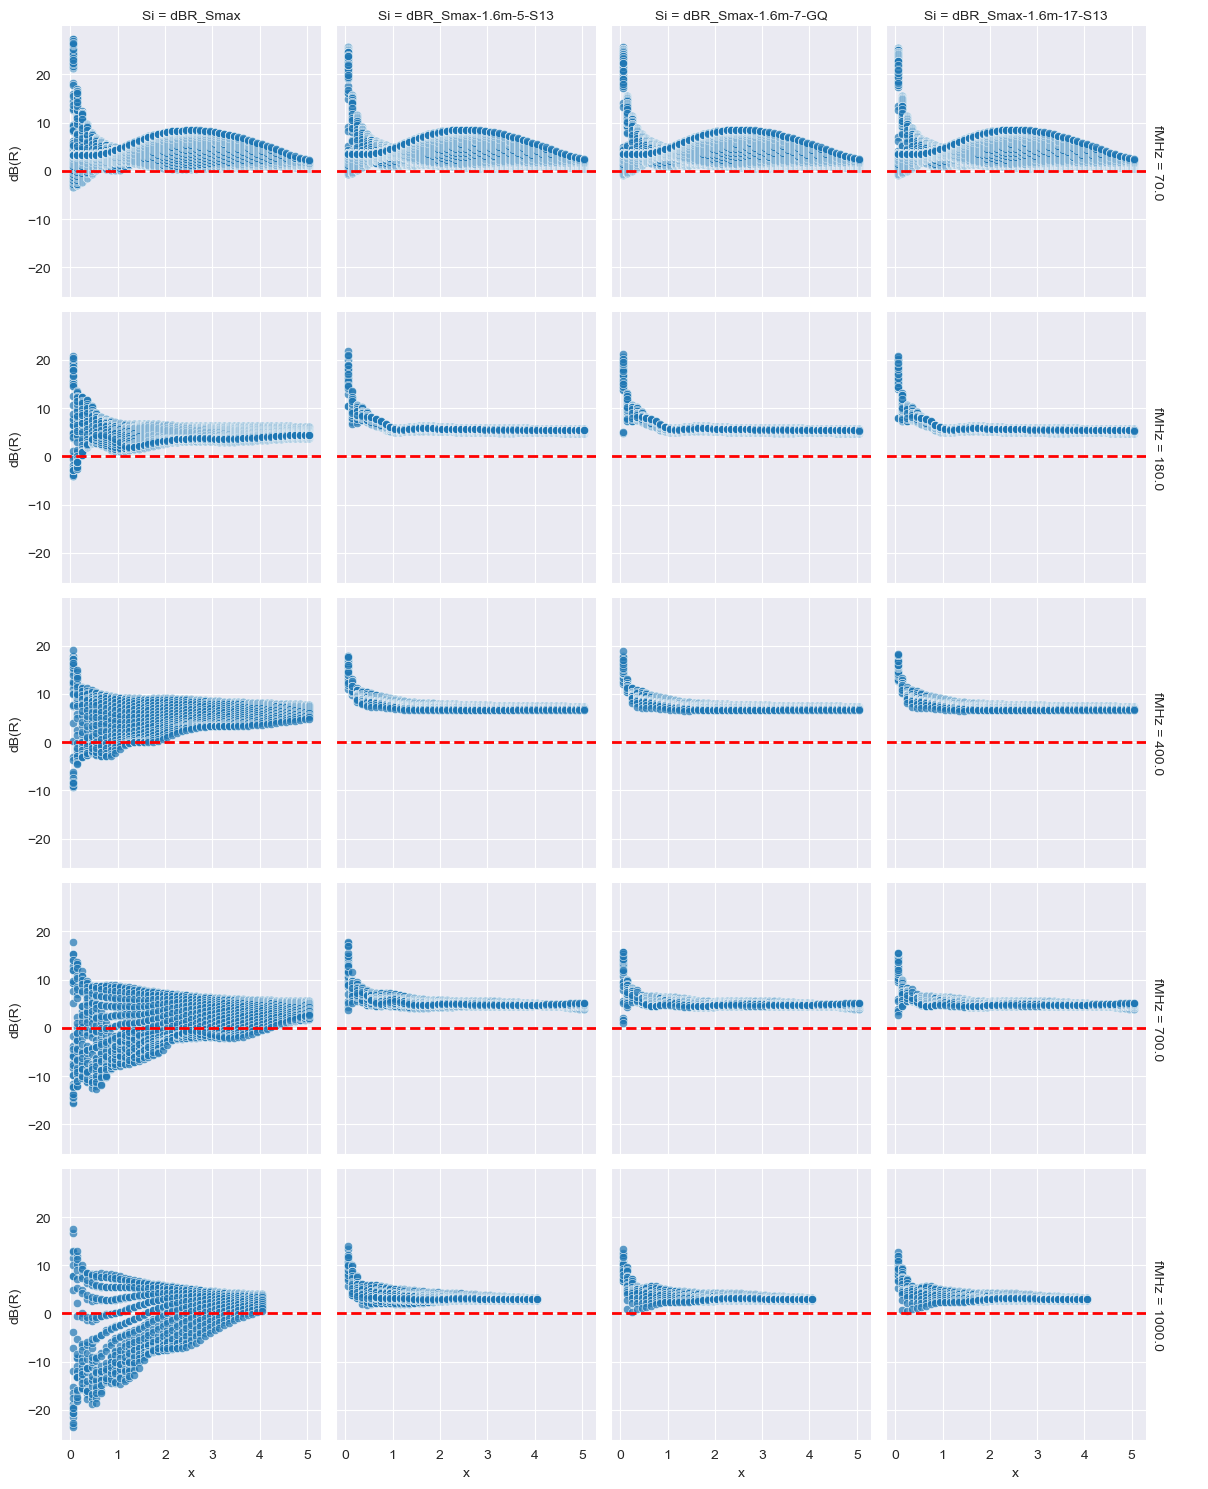

In [386]:
cols = ['x','z','fMHz','dBR_Smax','dBR_Smax-1.6m-5-S13','dBR_Smax-1.6m-7-GQ','dBR_Smax-1.6m-17-S13']
df = Sall2[cols].melt(id_vars=cols[:3],value_vars=cols[3:],var_name='Si',value_name='dB(R)')
g = sns.FacetGrid(df, row="fMHz",col="Si",margin_titles=True)
g.map(sns.scatterplot, "x", "dB(R)",alpha=.7)
g.refline(y=0,color="red",lw=2)
g.add_legend();

#### Points lying b/w compliance boundaries

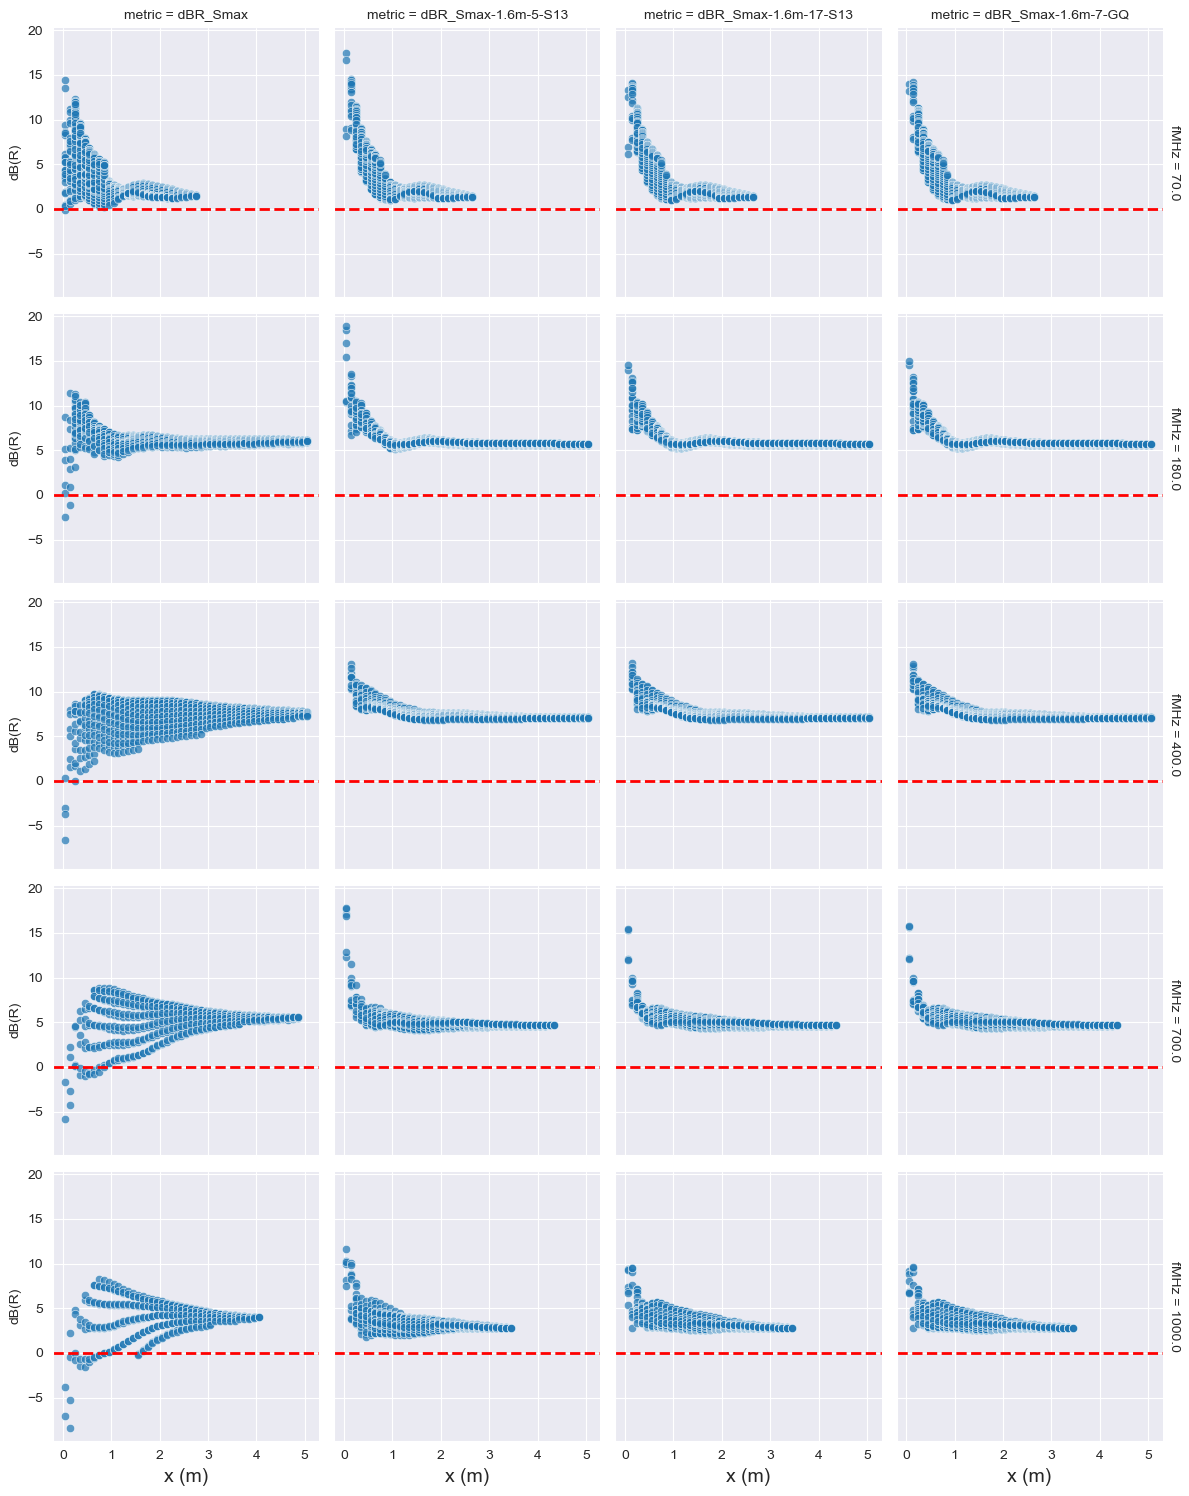

In [387]:
cols = ['dBR_Smax','dBR_Smax-1.6m-5-S13','dBR_Smax-1.6m-7-GQ','dBR_Smax-1.6m-17-S13']
mask = SallR.metric.isin(cols)
g = sns.FacetGrid(SallR[mask], row="fMHz",col="metric",
                  margin_titles=True)
g.map(sns.scatterplot, "x", "value",alpha=.7)
g.refline(y=0,color="red",lw=2)
g.set_xlabels('x (m)', fontsize=14)
g.set_ylabels('dB(R)')
plt.savefig(PLOTDIR+f'dBR vs x scatterlots.png',dpi=200)

### Spatial assessment uncertainty
The `Smax-1.6m-17-S13` spatial averaging scheme is taken as the benchmark for a 'near-perfect' spatial average

$err = \frac{S_{sa}}{Smax-1.6m-17-S13}$

#### Histogram function for spatial avg error, x-weighted

In [425]:
def dBerr_hist(df,fMHz_list,Si_list,bins,figsize,xticks=None):
    '''Generate x-weighted histogram plots of dB(err) for the values
       specified in fMHz_list & Si_list
       INPUTS:
         df = dataframe of data points between compliance boundaries
              in long format (i.e., SallR)
         fMHz_list = list of frequencies to be plotted
         Si_list = list of Ssa spatial averaging options
         bins = histogram bins
         figsize = tuple for figures size (width, height) in inches
         xticks = xtick lables for the plots
         '''
    # Create the figure
    nrows = len(Si_list)
    ncols = len(fMHz_list)
    fig, axes = plt.subplots(nrows,ncols,figsize=figsize,
                             sharex=True,sharey=True)

    # Plot the histograms
    for i, fMHz in enumerate(fMHz_list):
        for j, Si in enumerate(Si_list):
            # mask = cbmask(df, Si, fMHz, lowp, highp)
            ax = axes[j,i]
            dBerrcol = 'dBerr_' + Si
            mask = (df.fMHz == fMHz) & (df.metric == dBerrcol)
            data = df.loc[mask,'value'].values
            wtx = df.loc[mask,'wtx'].values
            data_wtx = np.repeat(data, wtx)
            ax.hist(data_wtx,bins=bins,density=True)
            CI95 = np.percentile(data_wtx,[2.5,97.5]).round(1)
            µ = data_wtx.mean()
            ax.set_xlim(bins.min(),bins.max())
            ax.axvline(0,color='red',ls='--')
            if j == 0:
                title = f'{fMHz} (MHz)'
                ax.set_title(title, fontsize=12,color='green')
            CItext = f'95% CI:\n{CI95[0]} to {CI95[1]} dB\nµ = {µ:0.2f} dB\n{sum(mask):,g} points'
            ax.text(0.05, 0.96, CItext,fontsize=8,color='navy',
                    horizontalalignment='left',verticalalignment='top',
                    transform=ax.transAxes)
            if isinstance(xticks, Iterable): ax.set_xticks(xticks)
            if i%nrows == 0: ax.set_ylabel("Probability density")
            if j == nrows-1: ax.set_xlabel("dB(R)")
            if i == ncols-1:
                ax.text(1.05, 0.5, Si, horizontalalignment='center',color='g',
                        rotation=-90,verticalalignment='center', fontsize=12,
                        transform=ax.transAxes)
    fig.suptitle('dB(err) histograms for points between compliance boundaries\nweighted by x\n',
                 color='black', fontsize=14)
    fig.tight_layout()                
    plt.savefig(PLOTDIR+f'dBerr histograms for {fMHz_list}.png',dpi=200)

#### 70, 180, 400 MHz

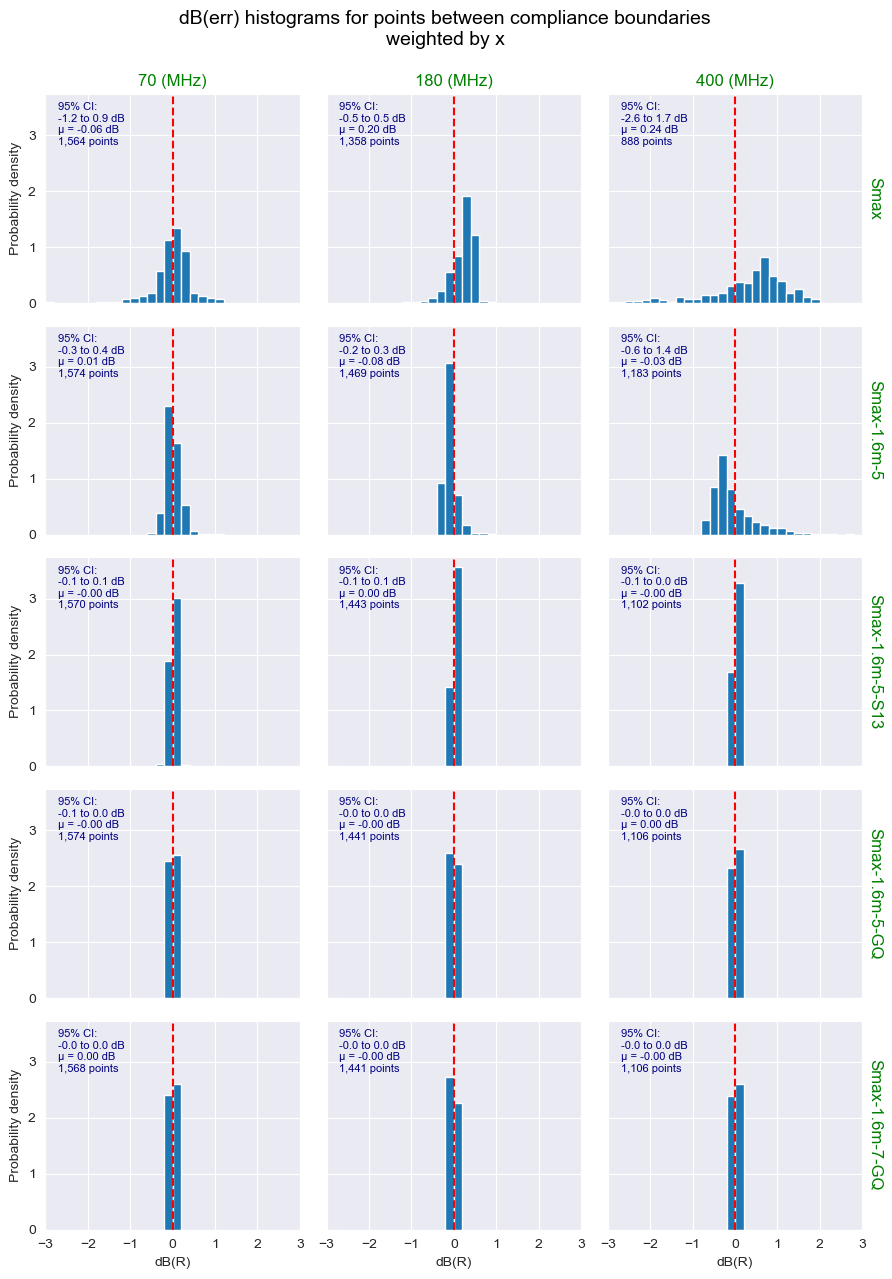

In [426]:
fMHz_list = [70,180,400]
Si_list = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ','Smax-1.6m-7-GQ']
df = SallR
bins = np.arange(-3,3.2,0.2)
xticks = np.arange(-3,4,1)
dBerr_hist(SallR,fMHz_list,Si_list,bins,figsize=(9,13),xticks=xticks)

#### 700, 1000 MHz

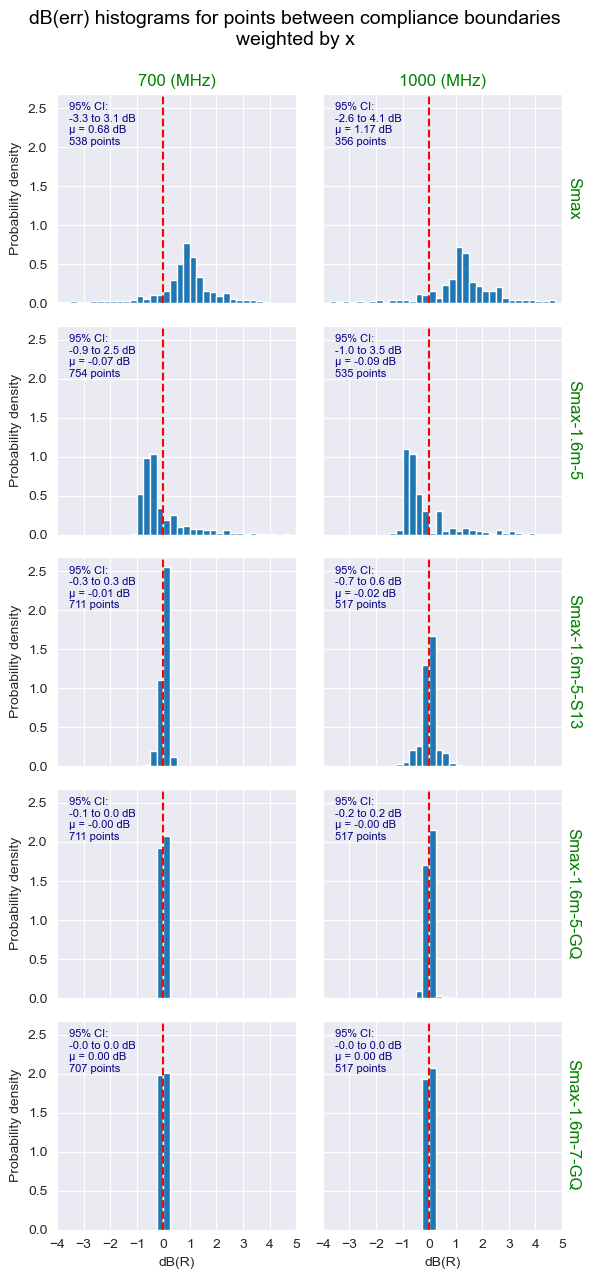

In [427]:
fMHz_list = [700,1000]
Si_list = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ','Smax-1.6m-7-GQ']
df = SallR
bins = np.arange(-4,5.25,0.25)
xticks = range(-4,6,1)
dBerr_hist(SallR,fMHz_list,Si_list,bins,figsize=(6,13),xticks=xticks)

#### dB(err) stats

##### Sall2

In [391]:
# First look at stats for Sall2
cols = ['fMHz'] + [col for col in Sall2.columns if 'dBerr' in col]
df = Sall2[cols]\
  .groupby('fMHz')\
  .describe()\
  .drop(columns=['25%','50%','75%'],level=1)\
  .T.style\
  .format('{:0.2f}')\
  .format_index(formatter='{:,g}', axis=1)
df

##### SallR

In [392]:
# Next look at stats of SallR
dBerr_list = [s for s in SallR.metric if 'dBerr' in s]
mask = SallR.metric.isin(dBerr_list)
SallR.loc[mask,['fMHz','metric','value']]\
  .groupby(['fMHz','metric'])\
  .describe()\
  .drop(columns=['25%','50%','75%'],level=1)\
  .unstack(sort=False)\
  .T\
  .swaplevel(2,1)\
  .sort_index(axis=0,level=1)\
  .style\
  .format('{:0.2f}')\
  .format_index(formatter='{:,g}', axis=1)

##### SallR x-weighted

In [535]:
def showErrStats(df, Ssa_list, fMHz_list):
    table = []
    for fMHz in fMHz_list:
        for Ssa in Ssa_list: 
            Rcol = f'dBerr_{Ssa}'
            mask = (df.metric==Rcol) & (df.fMHz==fMHz)
            data = df.loc[mask,'value'].values
            wtx = df.loc[mask,'wtx'].values
            data_wtx = np.repeat(data, wtx)
            dataname = ''
            mean_wtx = np.mean(data_wtx).round(2)
            ci = np.percentile(data_wtx,[2.5,97.5]).round(1)
            ci95 = f'{ci[0]} to {ci[1]}'
            table.append([fMHz,Ssa,mean_wtx,ci95])
    table = pd.DataFrame(table,columns=('Freq (MHz)','Ssa','Mean (dB)','95% CI (dB)'))
    table = table.set_index(['Freq (MHz)','Ssa'])
    table.columns.name = dataname
    
    return table

fMHz_list = [70,180,400,700,1000]
Ssa_list = ['Smax','Smax-1.6m-5','Smax-1.6m-5-S13','Smax-1.6m-5-GQ','Smax-1.6m-7-GQ','Smax-1.6m-17-S13']
showErrStats(SallR, Ssa_list, fMHz_list)

Mean (dB)  95% CI (dB)
Freq (MHz) Ssa                                     
70         Smax                  -0.06  -1.2 to 0.9
           Smax-1.6m-5            0.01  -0.3 to 0.4
           Smax-1.6m-5-S13       -0.00  -0.1 to 0.1
           Smax-1.6m-5-GQ        -0.00  -0.1 to 0.0
           Smax-1.6m-7-GQ         0.00  -0.0 to 0.0
           Smax-1.6m-17-S13       0.00   0.0 to 0.0
180        Smax                   0.20  -0.5 to 0.5
           Smax-1.6m-5           -0.08  -0.2 to 0.3
           Smax-1.6m-5-S13        0.00  -0.1 to 0.1
           Smax-1.6m-5-GQ        -0.00  -0.0 to 0.0
           Smax-1.6m-7-GQ        -0.00  -0.0 to 0.0
           Smax-1.6m-17-S13       0.00   0.0 to 0.0
400        Smax                   0.24  -2.6 to 1.7
           Smax-1.6m-5           -0.03  -0.6 to 1.4
           Smax-1.6m-5-S13       -0.00  -0.1 to 0.0
           Smax-1.6m-5-GQ         0.00  -0.0 to 0.0
           Smax-1.6m-7-GQ        -0.00  -0.0 to 0.0
           Smax-1.6m-17-S13       0.00   0.0 to 0.0
700        Smax                   0.68  -3.3 to 3.1
           Smax-1.6m-5           -0.07  -0.9 to 2.5
           Smax-1.6m-5-S13       -0.01  -0.3 to 0.3
           Smax-1.6m-5-GQ        -0.00  -0.1 to 0.0
           Smax-1.6m-7-GQ         0.00  -0.0 to 0.0
           Smax-1.6m-17-S13       0.00   0.0 to 0.0
1000       Smax                   1.17  -2.6 to 4.1
           Smax-1.6m-5           -0.09  -1.0 to 3.5
           Smax-1.6m-5-S13       -0.02  -0.7 to 0.6
           Smax-1.6m-5-GQ        -0.00  -0.2 to 0.2
           Smax-1.6m-7-GQ         0.00  -0.0 to 0.0
           Smax-1.6m-17-S13       0.00   0.0 to 0.0

#### Smax dB(err) stats

##### Scatter plots by fMHz

In [393]:
mask = (SallR.metric=='dBerr_Smax') # & (SallR.fMHz==70)

chart = alt.Chart(SallR[mask]).mark_circle(size=10).encode(
    x='x',
    y='z',
    color=alt.Color("value:Q", title='dB(err)')\
             .scale(scheme='blueorange',domain=[-8,8],bins=np.arange(-8,12,2)),
    tooltip=['x', 'z', 'value'],
    facet=alt.Facet('fMHz:O', columns=2),
).properties(
    width=220,
    height=220,
    title='dB(err) of Smax'
).interactive()
chart

alt.Chart(...)

##### dBerr_Smax mean & std dataframe

In [394]:
# Generate dataframe of mean and std of dBerr_Smax grouped by x and fMHz
dBerrSmax = SallR[(SallR.metric == 'dBerr_Smax')]
stats = dBerrSmax.groupby(['fMHz','x'])['value'].agg(['mean','std']).reset_index()
stats
stats.to_csv(OUTDIR + 'dBerr Smax mean & sd.csv')

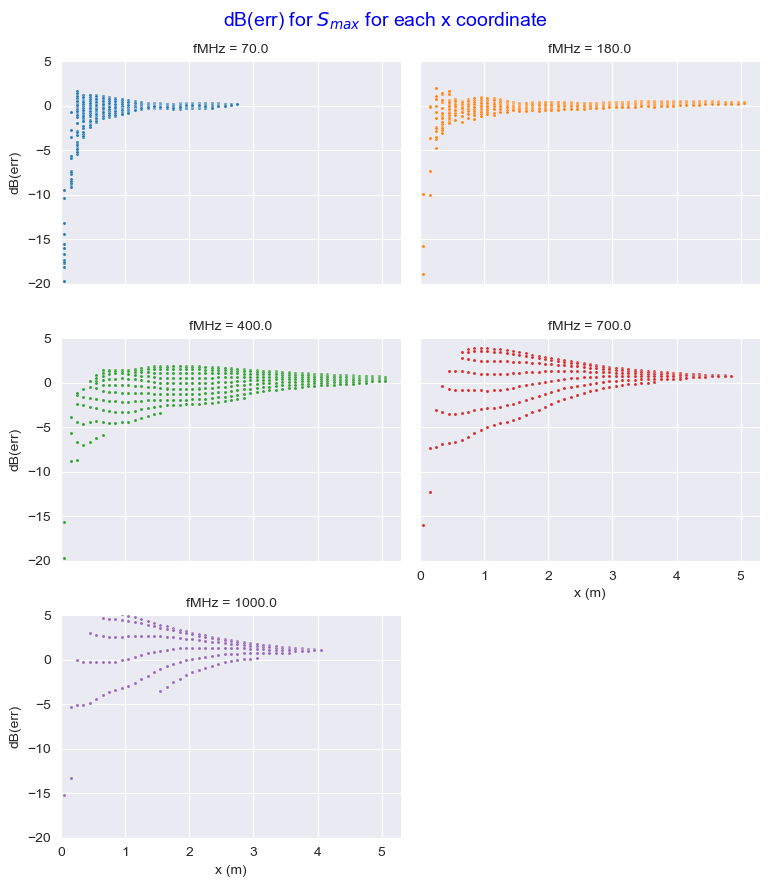

In [395]:
g = sns.FacetGrid(data=dBerrSmax,col='fMHz',col_wrap=2,
                  hue='fMHz',aspect=1.3)
g.map(sns.scatterplot,'x','value',markers=True, s=5)
g.set(xlim=(0, None),ylim=(-20,5),ylabel='dB(err)',
      xlabel='x (m)')
g.fig.suptitle('dB(err) for $S_{max}$ for each x coordinate',
               fontsize=14,color='b')
g.fig.tight_layout()
g.fig.savefig(PLOTDIR+f'dBerr scatter by fMHz.png',dpi=200);

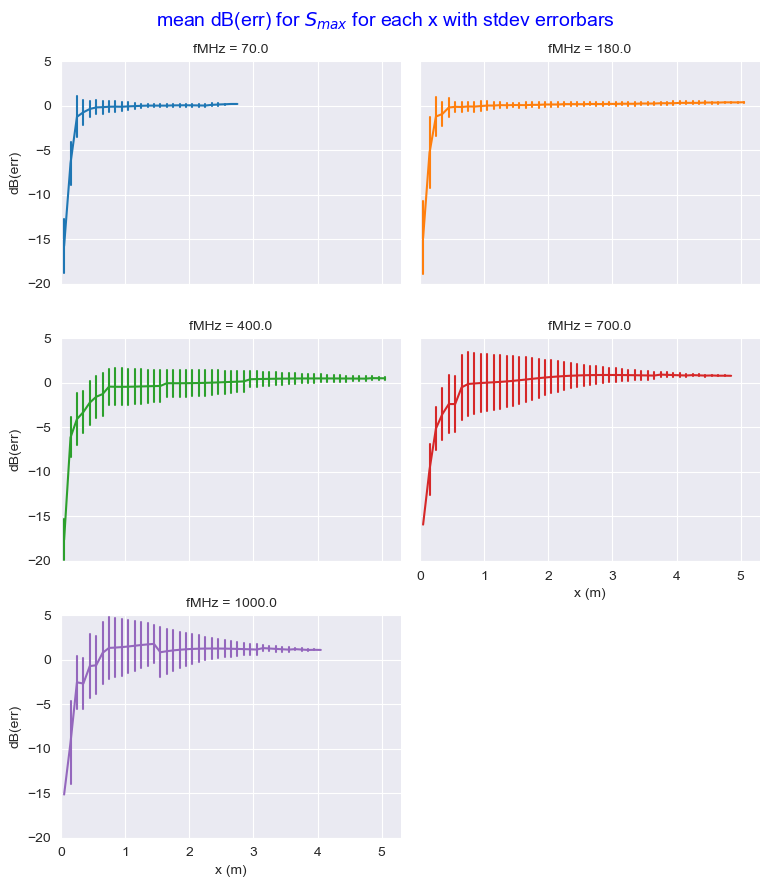

In [396]:
g = sns.FacetGrid(data=dBerrSmax,col='fMHz',col_wrap=2,
                  hue='fMHz',aspect=1.3)
g.map(sns.lineplot,'x','value',ci='sd',err_style='bars',
      markers=True)
g.set(xlim=(0, None),ylim=(-20,5),ylabel='dB(err)',
      xlabel='x (m)')
g.fig.suptitle('mean dB(err) for $S_{max}$ for each x with stdev errorbars',
               fontsize=14,color='b')
g.fig.tight_layout()
g.fig.savefig(PLOTDIR+f'dBerr mean & sd by fMHz.png',dpi=200);

## Scratch

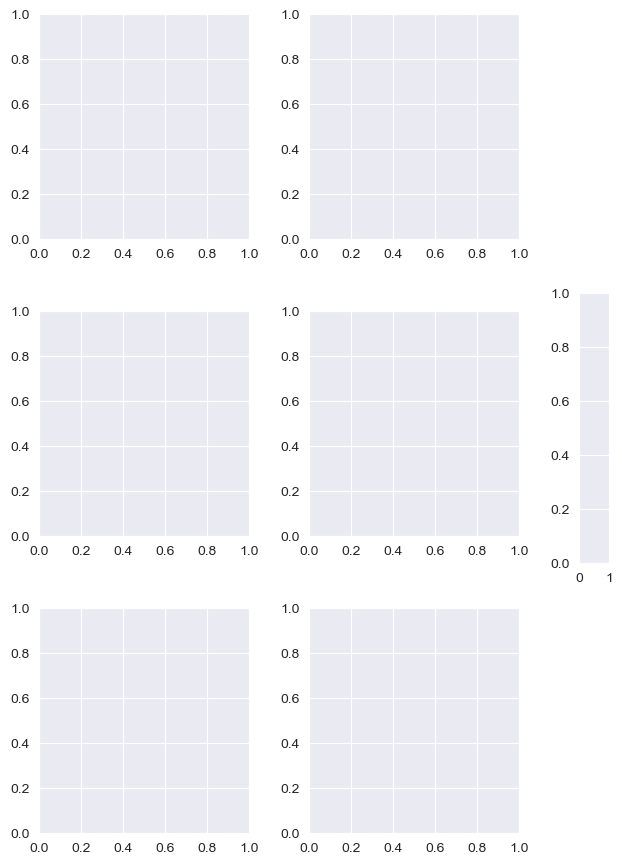

In [397]:
fig = plt.figure(figsize=(6,9))
axes = []
width = 0.35
height = 0.25
for left in [0,0.45]:
    for bottom in [0.66,0.33,0]:
        axes.append(fig.add_axes([left,bottom,width,height]))
axes.append(fig.add_axes([0.9,0.3,0.05,0.3]))